In [ ]:
!pip install tensorflow==2.9.2
!pip install wget==3.2
!pip install pymorphy2==0.9.1
!pip install pytorch_pretrained_bert==0.6.2
!pip install pandas==1.3.5
!pip install numpy==1.21.6
!pip install matplotlib==3.2.2
!pip install tqdm==4.64.1
!pip install torch==1.12.1
!pip install scikit-learn==1.0.2
!pip install nltk==3.7
!pip install python-docx==0.8.11
!pip install transformers==2.11.0

In [ ]:
import json
import os
import random
import nltk
from nltk.corpus import stopwords
import pymorphy2
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
import re
import pickle
import tqdm
from tqdm import tqdm, trange
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM, Bidirectional, GRU
from tensorflow.keras.models import Model, Sequential
from keras.layers.normalization.batch_normalization import BatchNormalization

from sklearn.metrics import classification_report # импортируем метод вычисления основных метрик
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from time import time

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences

from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import wget
import gensim
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
 #Установление параметра random state для библиотек numpy, random, pytorch, os, transformers 
SEED = 11

def set_seed_pytorch(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed_pytorch(SEED)

from transformers import set_seed
set_seed(SEED)

Random seed set as 11


In [ ]:
path_to_dir='' #указываем путь

In [ ]:
# -*- coding: utf-8 -*-
from docx import Document
document = Document()

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Функция для сохранения датафрейма в файл
def save_to_file(result, columns, path_to_file):
    new = pd.DataFrame(data=result,
                       columns=columns)
    if os.path.exists(path_to_file)==True:
        df=pd.read_csv(path_to_file)
        df.drop('Unnamed: 0', axis = 1, inplace=True)
        new = pd.DataFrame(data=result,
                           columns=columns)
        df=df.append(new)
    else:
        df=new
    df.to_csv(path_to_file)

### Выбор тестовых данных для разметки

In [ ]:
try:
  
    test_data=[]
    for line in open(path_to_dir+"./test.jsonl", "r"):
        test_data.append(json.loads(line))

except FileNotFoundError as e:
    print(e)

In [ ]:
test_data=random.sample(test_data, 400)

In [ ]:
for test_seq in test_data:
    document.add_paragraph(str(test_seq))
document.save(path_to_dir+'./test.docx')

In [ ]:
doc=Document(path_to_dir+'./test.docx')
all_paras = doc.paragraphs

test_data=[]
for paragraph in all_paras:
    test_data.append(paragraph.text)

In [ ]:
with open(path_to_dir+'./test.jsonl', 'w') as f:
    f.write(json.dumps(test_data))

### Загрузка данных

In [ ]:
try:

    train_data=[]
    for line in open(path_to_dir+"./train.jsonl", "r"):
        train_data.append(json.loads(line))

    val_data=[]
    for line in open(path_to_dir+"./val.jsonl", "r"):
        val_data.append(json.loads(line))

    with open(path_to_dir+"./test.jsonl", "r") as f:
        test_data1=json.load(f)

    test_data=[]
    for test in test_data1:
        test_data.append(eval(test))

except FileNotFoundError as e:
    print(e)

In [ ]:
train_data_len=len(train_data)
val_data_len=len(val_data)
test_data_len=len(test_data)
print(train_data_len, val_data_len, test_data_len)

1749 821 400


In [ ]:
neg=0
pos=0
for train in train_data:
    if train['label']==True:
        pos+=1
    else:
        neg+=1
print('Train labels count: true -', pos, ', false -', neg)

Train labels count: true - 1061 , false - 688


In [ ]:
neg=0
pos=0
for val in val_data:
    if val['label']==True:
        pos+=1
    else:
        neg+=1
print('Validation labels count: true -', pos, 'false -', neg)

Validation labels count: true - 412 false - 409


In [ ]:
neg=0
pos=0
for test in test_data:
    if test['label']==True:
        pos+=1
    else:
        neg+=1
print('Test labels count: true -', pos, 'false -', neg)

Test labels count: true - 190 false - 210


In [ ]:
train_data[0]

{'question': 'Вднх - это выставочный центр?',
 'passage': '«Вы́ставочный центр» — станция Московского монорельса. Расположена между станциями «Улица Академика Королёва» и «Улица Сергея Эйзенштейна». Находится на территории Останкинского района Северо-Восточного административного округа города Москвы. Переход на станцию  ВДНХ Калужско-Рижской линии. Названа в честь Всероссийского выставочного центра — названия ВДНХ с 1992 по 2014 год. 20 ноября 2004 года линия монорельса начала работать в «экскурсионном режиме» и перевезла первых пассажиров .',
 'label': True,
 'idx': 0}

In [ ]:
test_data[0]

{'question': 'Бывает ли аллергия на серебро?',
 'passage': 'При продолжительном избыточном поступлении серебра в организм возникает такое специфическое заболевание как аргироз — отравление серебром. Оно не представляет угрозу для жизни, но голубовато-серый оттенок кожи вряд ли кого-либо порадует. По данным Агентства по охране окружающей среды США, аргироз вызывается накоплением в организме в среднем 1 грамма серебра. Разовая доза нитрата серебра в 10 грамм  оценивается ВОЗ как смертельная. Нитрат серебра является наиболее токсичным из препаратов ионного серебра.',
 'label': False,
 'idx': 86}

Создадим списки отдельно для вопросов и отдельно для отрывков

In [ ]:
questions=[]
passages=[]

for i in range(train_data_len):
    questions.append(train_data[i]['question'])
    passages.append(train_data[i]['passage'])

for j in range(val_data_len):
    questions.append(val_data[j]['question'])
    passages.append(val_data[j]['passage'])

In [ ]:
test_questions=[]
test_passages=[]

for i in range(test_data_len):
    test_questions.append(test_data[i]['question'])
    test_passages.append(test_data[i]['passage'])

# Применение моделей

## Подготовка данных

### Обработка данных (токенизация, удаление стоп слов, лемматизация)

In [ ]:
def clear_txt(txt):
    txt = txt.lower()
    txt = re.sub('[\&’\*=\^`№%—/+_–''!?@#$\n.,:()""«»;-]', '', txt)
    txt = re.sub(r'\[*\]*\{*\}*', '', txt)
    return txt

def lemmatize(words):
    res = []
    for word in words:
        p = morph.parse(word)[0]
        res.append(p.normal_form)
    return res

In [ ]:
stop_w = stopwords.words('russian')

In [ ]:
tokenized_questions=[]
tokenized_passages=[]
morph = pymorphy2.MorphAnalyzer()

for question in tqdm(questions):
    clear_text = clear_txt(question)
    text_tokens = nltk.word_tokenize(clear_text)
    remove_sw = [word for word in text_tokens if not word in stop_w]
    lemma_text = lemmatize(remove_sw)
    tokenized_questions.append(lemma_text)

for passage in tqdm(passages):
    clear_text = clear_txt(passage)
    text_tokens = nltk.word_tokenize(clear_text)
    remove_sw = [word for word in text_tokens if not word in stop_w]
    lemma_text = lemmatize(remove_sw)
    tokenized_passages.append(lemma_text)

100%|██████████| 2570/2570 [00:42<00:00, 60.60it/s]


In [ ]:
tokenized_questions[0]

['вднх', 'это', 'выставочный', 'центр']

Сохраним tokenized_questions и tokenized_passages

In [ ]:
# сохранить
with open(path_to_dir+'transformed_data/tokenized_questions.pickle', 'wb') as f:
    pickle.dump(tokenized_questions, f)
with open(path_to_dir+'transformed_data/tokenized_passages.pickle', 'wb') as f:
    pickle.dump(tokenized_passages, f)

Загрузка tokenized_questions и tokenized_passages, создание частотного словаря.

In [ ]:
with open(path_to_dir+'transformed_data/tokenized_questions.pickle', 'rb') as f:
    tokenized_questions=pickle.load(f)
with open(path_to_dir+'transformed_data/tokenized_passages.pickle', 'rb') as f:
    tokenized_passages=pickle.load(f)

In [ ]:
words=[]

for question in tokenized_questions:
    for w in question:
        words.append(w)

for passages in tokenized_passages:
    for w in passages:
        words.append(w)  

word_index_ = dict(Counter(words))
print(len(word_index_))

word_index_ = {k: v for k, v in word_index_.items() if v >= 5}
print(len(word_index_))

27394
6537


In [ ]:
sorted_values = sorted(word_index_.values()) #Сортировка словаря Python по значению
sorted_values.reverse()
word_index_sort = {}

for i, v in tqdm(enumerate([i for i in sorted_values])):
    for k in word_index_.keys():

        if word_index_[k] == v:
            word_index_sort[k] = word_index_[k]

6537it [00:06, 998.84it/s]


In [ ]:
word_index = {k: i+1 for i, k in enumerate(word_index_sort.keys())}

In [ ]:
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNKNOWN>"] = 2
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
    
print('Кол-во слов в словаре - ', len(word_index))

Кол-во слов в словаре -  6541


In [ ]:
with open(path_to_dir+'transformed_data/words_dictionary.pickle', 'wb') as f:
    pickle.dump(word_index, f)

In [ ]:
questions_vectors=[]
passages_vectors=[]

for question in tqdm(tokenized_questions):
    data=[]
    data.append(1)
    for word in question:
        if word_index.get(word):
        data.append(word_index[word])
        else:
            data.append(2)
    questions_vectors.append(data)

for passage in tqdm(tokenized_passages):
    data=[]
    data.append(1)
    for word in passage:
        if word_index.get(word):
        data.append(word_index[word])
        else:
            data.append(2)
    passages_vectors.append(data)

100%|██████████| 2570/2570 [00:00<00:00, 38440.61it/s]


In [ ]:
questions_vectors[0]

[1, 3964, 13, 3064, 193]

In [ ]:
# Вывод минимальной, максимальной и средней длин вопросов и отрывков

print("Maximum question length: {}".format(len(max((questions_vectors), key=len))))
print("Minimum question length: {}".format(len(min((questions_vectors), key=len))))
result1 = [len(x) for x in questions_vectors]
print("Mean question length: {}".format(np.mean(result1)))

print("\nMaximum passage length: {}".format(len(max((passages_vectors), key=len))))
print("Minimum passage length: {}".format(len(min((passages_vectors), key=len))))
result2 = [len(x) for x in passages_vectors]
print("Mean passage length: {}".format(np.mean(result2)))

Maximum question length: 22
Minimum question length: 2
Mean question length: 4.728015564202335

Maximum passage length: 328
Minimum passage length: 30
Mean passage length: 72.3


In [ ]:
question_maxlen=6
passage_maxlen=74

questions_vectors=pad_sequences(questions_vectors, maxlen=question_maxlen, truncating='post', padding='post')
passages_vectors=pad_sequences(passages_vectors, maxlen=passage_maxlen, truncating='post', padding='post')

In [ ]:
questions_vectors[0]

array([   1, 3964,   13, 3064,  193,    0], dtype=int32)

In [ ]:
passages_vectors[0]

array([   1,    2,  193,  634,  354, 5070,  341,  634,  649, 2896, 4488,
        649, 1368,    2,   76,   47,    2,  342, 2176, 1607,  520,   33,
        210,  764,  634, 3964,    2,  451,  486,  922, 3156, 3064,  193,
         95, 3964, 2177,  655,    4,  321,  316, 1075,    4,  451, 5070,
         57,  360,    2,  653,    2,   11, 1863,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
len(np.hstack((questions_vectors, passages_vectors))[0])

80

Сохранение полученных векторов

In [ ]:
with open(path_to_dir+'transformed_data/questions_vectors.pickle', 'wb') as f:
    pickle.dump(questions_vectors, f)
with open(path_to_dir+'transformed_data/passages_vectors.pickle', 'wb') as f:
    pickle.dump(passages_vectors, f)

### Обработка тестовых данных

In [ ]:
test_tokenized_questions=[]
test_tokenized_passages=[]
morph = pymorphy2.MorphAnalyzer()

for question in tqdm(test_questions):
    clear_text = clear_txt(question)
    text_tokens = nltk.word_tokenize(clear_text)
    remove_sw = [word for word in text_tokens if not word in stop_w]
    lemma_text = lemmatize(remove_sw)
    test_tokenized_questions.append(lemma_text)

for passage in tqdm(test_passages):
    clear_text = clear_txt(passage)
    text_tokens = nltk.word_tokenize(clear_text)
    remove_sw = [word for word in text_tokens if not word in stop_w]
    lemma_text = lemmatize(remove_sw)
    test_tokenized_passages.append(lemma_text)

100%|██████████| 400/400 [00:04<00:00, 98.12it/s]


In [ ]:
with open(path_to_dir+'/transformed_data/words_dictionary.pickle', 'rb') as f:
    word_index=pickle.load(f)

In [ ]:
test_questions_vectors=[]
test_passages_vectors=[]

for question in tqdm(test_tokenized_questions):
    data=[]
    data.append(1)
    for word in question:
        if word_index.get(word):
            data.append(word_index[word])
        else:
            data.append(2)
    test_questions_vectors.append(data)

for passage in tqdm(test_tokenized_passages):
    data=[]
    data.append(1)
    for word in passage:
        if word_index.get(word):
            data.append(word_index[word])
        else:
            data.append(2)
    test_passages_vectors.append(data)

100%|██████████| 400/400 [00:00<00:00, 33073.54it/s]


In [ ]:
question_maxlen=6
passage_maxlen=74

test_questions_vectors=pad_sequences(test_questions_vectors, maxlen=question_maxlen, truncating='post', padding='post')
test_passages_vectors=pad_sequences(test_passages_vectors, maxlen=passage_maxlen, truncating='post', padding='post')

In [ ]:
with open(path_to_dir+'transformed_data/test_questions_vectors.pickle', 'wb') as f:
    pickle.dump(test_questions_vectors, f)
with open(path_to_dir+'transformed_data/test_passages_vectors.pickle', 'wb') as f:
    pickle.dump(test_passages_vectors, f)

### Получение эмбеддингов слов с помощью Word2vec

Загрузим модель Word2vec, предобученную на русском языке. И получим эмбеддинги для слов.

In [ ]:
!wget -P './' 'http://vectors.nlpl.eu/repository/20/65.zip' 

--2022-10-24 13:25:25--  http://vectors.nlpl.eu/repository/20/65.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.181
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2540031150 (2.4G) [application/zip]
Saving to: ‘./65.zip’

65.zip              100%[===================>]   2.37G  17.4MB/s    in 2m 22s  

2022-10-24 13:27:48 (17.0 MB/s) - ‘./65.zip’ saved [2540031150/2540031150]



In [ ]:
with zipfile.ZipFile('./65.zip', 'r') as archive:
    stream = archive.open('model.bin')
    model_word2vec = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)

Создадим embeddings matrix

In [ ]:
embedding_dim=100
embedding_matrix = np.zeros((len(word_index), embedding_dim))
for word, i in word_index.items():
    if i >= len(word_index):
        continue 
    try:
        embedding_matrix[i] = model_word2vec[word]
    except:
        pass

In [ ]:
with open(path_to_dir+'transformed_data/embedding_matrix_word2vec.pickle', 'wb') as f:
    pickle.dump(embedding_matrix, f)

### Получение эмбеддингов слов с помощью GLOVE

Загрузим модель GLOVE. И получим эмбеддинги для слов.

In [ ]:
with zipfile.ZipFile(path_to_dir+'archive(2).zip', 'r') as archive:
    stream = archive.open('multilingual_embeddings.ru')
    df = pd.read_csv(stream, sep=" ", quoting = 3, index_col=0)

In [ ]:
emb_dict = {key: val.values for key ,val in df.T.items()}

In [ ]:
with open(path_to_dir+'/transformed_data/words_dictionary.pickle', 'rb') as f:
    word_index=pickle.load(f)

Создадим embeddings matrix

In [ ]:
embedding_dim=300
embedding_matrix = np.zeros((len(word_index), embedding_dim))
for word, i in word_index.items():
    if i >= len(word_index):
        continue 
    try:
        embedding_matrix[i] = emb_dict[word]
    except:
        pass

In [ ]:
with open(path_to_dir+'transformed_data/embedding_matrix_glove.pickle', 'wb') as f:
    pickle.dump(embedding_matrix, f)

## Получение обучающей, валидационной и тестовой выборок для моделей Logistic Regression, KNN

In [ ]:
with open(path_to_dir+'transformed_data/questions_vectors.pickle', 'rb') as f:
    questions_vectors=pickle.load(f)
with open(path_to_dir+'transformed_data/passages_vectors.pickle', 'rb') as f:
    passages_vectors=pickle.load(f)
with open(path_to_dir+'transformed_data/test_questions_vectors.pickle', 'rb') as f:
    test_questions_vectors=pickle.load(f)
with open(path_to_dir+'transformed_data/test_passages_vectors.pickle', 'rb') as f:
    test_passages_vectors=pickle.load(f)

In [ ]:
with open(path_to_dir+'transformed_data/embedding_matrix_word2vec.pickle', 'rb') as f:
    embedding_matrix=pickle.load(f)

In [ ]:
with open(path_to_dir+'transformed_data/embedding_matrix_glove.pickle', 'rb') as f:
    embedding_matrix_glove=pickle.load(f)

### Использование матриц эмбеддингов, предобученных на Word2vec и GLOVE, для представления данных в виде векторов

In [ ]:
all_data = np.hstack((questions_vectors, passages_vectors))
all_test_data = np.hstack((test_questions_vectors, test_passages_vectors))

In [ ]:
all_data[0]

array([   1, 3964,   13, 3064,  193,    0,    1,    2,  193,  634,  354,
       5070,  341,  634,  649, 2896, 4488,  649, 1368,    2,   76,   47,
          2,  342, 2176, 1607,  520,   33,  210,  764,  634, 3964,    2,
        451,  486,  922, 3156, 3064,  193,   95, 3964, 2177,  655,    4,
        321,  316, 1075,    4,  451, 5070,   57,  360,    2,  653,    2,
         11, 1863,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int32)

Чтобы получить векторное представление для предложения, которое состоит из вопроса и отрывка, будем использовать среднее арифметическое векторов слов, входящих в данное предложение.

In [ ]:
x_data=[]

for sentence in tqdm(all_data):
  data=[]
  for word in sentence:
    for i, embedding in enumerate(embedding_matrix):
      if word==i:
        data.append(np.array(embedding))
  x_data.append(np.array(data).mean(axis=0))

In [ ]:
with open(path_to_dir+'transformed_data/x_data_for_classic_methods', 'wb') as f:
  pickle.dump(x_data, f)

In [ ]:
x_data_glove=[]

for sentence in tqdm(all_data):
  data=[]
  for word in sentence:
    for i, embedding in enumerate(embedding_matrix_glove):
      if word==i:
        data.append(np.array(embedding))
  x_data_glove.append(np.array(data).mean(axis=0))

100%|██████████| 2570/2570 [35:26<00:00,  1.21it/s]


In [ ]:
with open(path_to_dir+'transformed_data/x_data_glove_for_classic_methods', 'wb') as f:
  pickle.dump(x_data_glove, f)

In [ ]:
x_test=[]

for sentence in tqdm(all_test_data):
  data=[]
  for word in sentence:
    for i, embedding in enumerate(embedding_matrix):
      if word==i:
        data.append(np.array(embedding))
  x_test.append(np.array(data).mean(axis=0))

100%|██████████| 400/400 [05:24<00:00,  1.23it/s]


In [ ]:
with open(path_to_dir+'transformed_data/x_test_for_classic_methods', 'wb') as f:
  pickle.dump(x_test, f)

In [ ]:
x_test_glove=[]

for sentence in tqdm(all_test_data):
  data=[]
  for word in sentence:
    for i, embedding in enumerate(embedding_matrix_glove):
      if word==i:
        data.append(np.array(embedding))
  x_test_glove.append(np.array(data).mean(axis=0))

100%|██████████| 400/400 [05:40<00:00,  1.18it/s]


In [ ]:
with open(path_to_dir+'transformed_data/x_test_glove_for_classic_methods', 'wb') as f:
  pickle.dump(x_test_glove, f)

### Получение обучающей, валидационной и тестовой выборок.

In [ ]:
y_train=[]
y_val=[]
y_test=[]

for i in range(train_data_len):
  y_train.append(train_data[i]['label'])

for j in range(val_data_len):
  y_val.append(val_data[j]['label'])

for i in range(test_data_len):
  y_test.append(test_data[i]['label'])

y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)

In [ ]:
with open(path_to_dir+'transformed_data/x_data_for_classic_methods', 'rb') as f:
  x_data=pickle.load(f)
with open(path_to_dir+'transformed_data/x_test_for_classic_methods', 'rb') as f:
  x_test=pickle.load(f)

In [ ]:
with open(path_to_dir+'transformed_data/x_data_glove_for_classic_methods', 'rb') as f:
  x_data_glove=pickle.load(f)
with open(path_to_dir+'transformed_data/x_test_glove_for_classic_methods', 'rb') as f:
  x_test_glove=pickle.load(f)

In [ ]:
x_train = np.array(x_data[:train_data_len])
x_val = np.array(x_data[train_data_len:train_data_len+val_data_len])
x_test = np.array(x_test)

In [ ]:
# Перемешивание y_train
randomize = np.arange(len(y_train))
np.random.shuffle(randomize)

y_train = y_train[randomize]

In [ ]:
# Перемешивание x_train
x_train = x_train[randomize]

In [ ]:
x_train_glove = np.array(x_data_glove[:train_data_len])
x_val_glove = np.array(x_data_glove[train_data_len:train_data_len+val_data_len])
x_test_glove = np.array(x_test_glove)

In [ ]:
# Перемешивание x_train
x_train_glove = x_train_glove[randomize]

In [ ]:
# Функция для оценки гиперпараметров экземпляра модели
def evaluate_params(model, X_train, y_train, X_val, y_val, params):
  model.set_params(**params)

  start=time()
  model.fit(X_train, y_train)
  exec_time=time()-start

  start2=time()
  y_train_pred=model.predict(X_train)
  acc_train=accuracy_score(y_train, y_train_pred)*100.0
  exec_time2=time()-start2

  start3=time()
  y_val_pred=model.predict(X_val)
  acc_val=accuracy_score(y_val, y_val_pred)*100.0
  exec_time3=time()-start3

  return acc_train, acc_val, exec_time, exec_time2+exec_time3, model

## Обучение Logistic Regression на предобученных эмбеддингах Word2vec

Оптимизация параметра max_iter.

In [ ]:
max_iter=5
iterations = 19

# Есть 3 решателя. Для каждого из них нам нужно увидеть их точность в наборах для обучения и проверки, а также время их сборки.
# Дополнительно, первые два столбца - это Sl и max_iter. Следовательно, всего требуется (3 * 4) + 2 = 14 столбцов.
results = np.zeros((iterations, 14))
solver_list1 = ['newton-cg', 'lbfgs', 'sag']

for i in trange(0,iterations):    
    model_params1 = {'max_iter':max_iter,'random_state': SEED}
    results[i][0:2] = i+1, max_iter
    
    j = 2 
    for solver in solver_list1:
        model_params1.update({'solver': solver})
        LogReg=LogisticRegression()
        acc_train, acc_val, fit_time, predict_time, _ = evaluate_params(LogReg, x_train, y_train, x_val, y_val, model_params1)
        results[i][j:j+4] = acc_train, acc_val, fit_time, predict_time
        j+=4
        
    max_iter += 5


100%|██████████| 19/19 [00:04<00:00,  3.97it/s]


In [ ]:
columns = ['Sl','max_iter']
for solver in solver_list1:
    columns.append('Train_acc_'+solver)
    columns.append('Val_acc_'+solver)
    columns.append('Build_time_'+solver)
    columns.append('Predict_time_'+solver)

res_df_solver_max_iter = pd.DataFrame( data=results[0:,0:], 
                                  index=results[0:,0],
                                  columns=columns)
res_df_solver_max_iter['Sl'] = res_df_solver_max_iter['Sl'].astype(np.uint16)
res_df_solver_max_iter.head()

,Sl,max_iter,Train_acc_newton-cg,Val_acc_newton-cg,Build_time_newton-cg,Predict_time_newton-cg,Train_acc_lbfgs,Val_acc_lbfgs,Build_time_lbfgs,Predict_time_lbfgs,Train_acc_sag,Val_acc_sag,Build_time_sag,Predict_time_sag
1.0,1,5.0,67.810177,54.202192,0.033854,0.004781,66.838193,53.593179,0.019202,0.002514,69.239565,55.298417,0.024943,0.002644
2.0,2,10.0,68.610635,55.176614,0.040926,0.002093,68.267581,55.054811,0.015643,0.002238,68.267581,55.298417,0.045099,0.003221
3.0,3,15.0,68.610635,55.176614,0.062791,0.003860,68.496284,55.298417,0.024984,0.002629,68.610635,55.176614,0.070454,0.010170
4.0,4,20.0,68.610635,55.176614,0.073312,0.006565,68.610635,55.054811,0.030865,0.009190,68.610635,55.176614,0.117823,0.012543
5.0,5,25.0,68.610635,55.176614,0.120404,0.003031,68.610635,55.176614,0.035334,0.002877,68.610635,55.176614,0.122779,0.006510


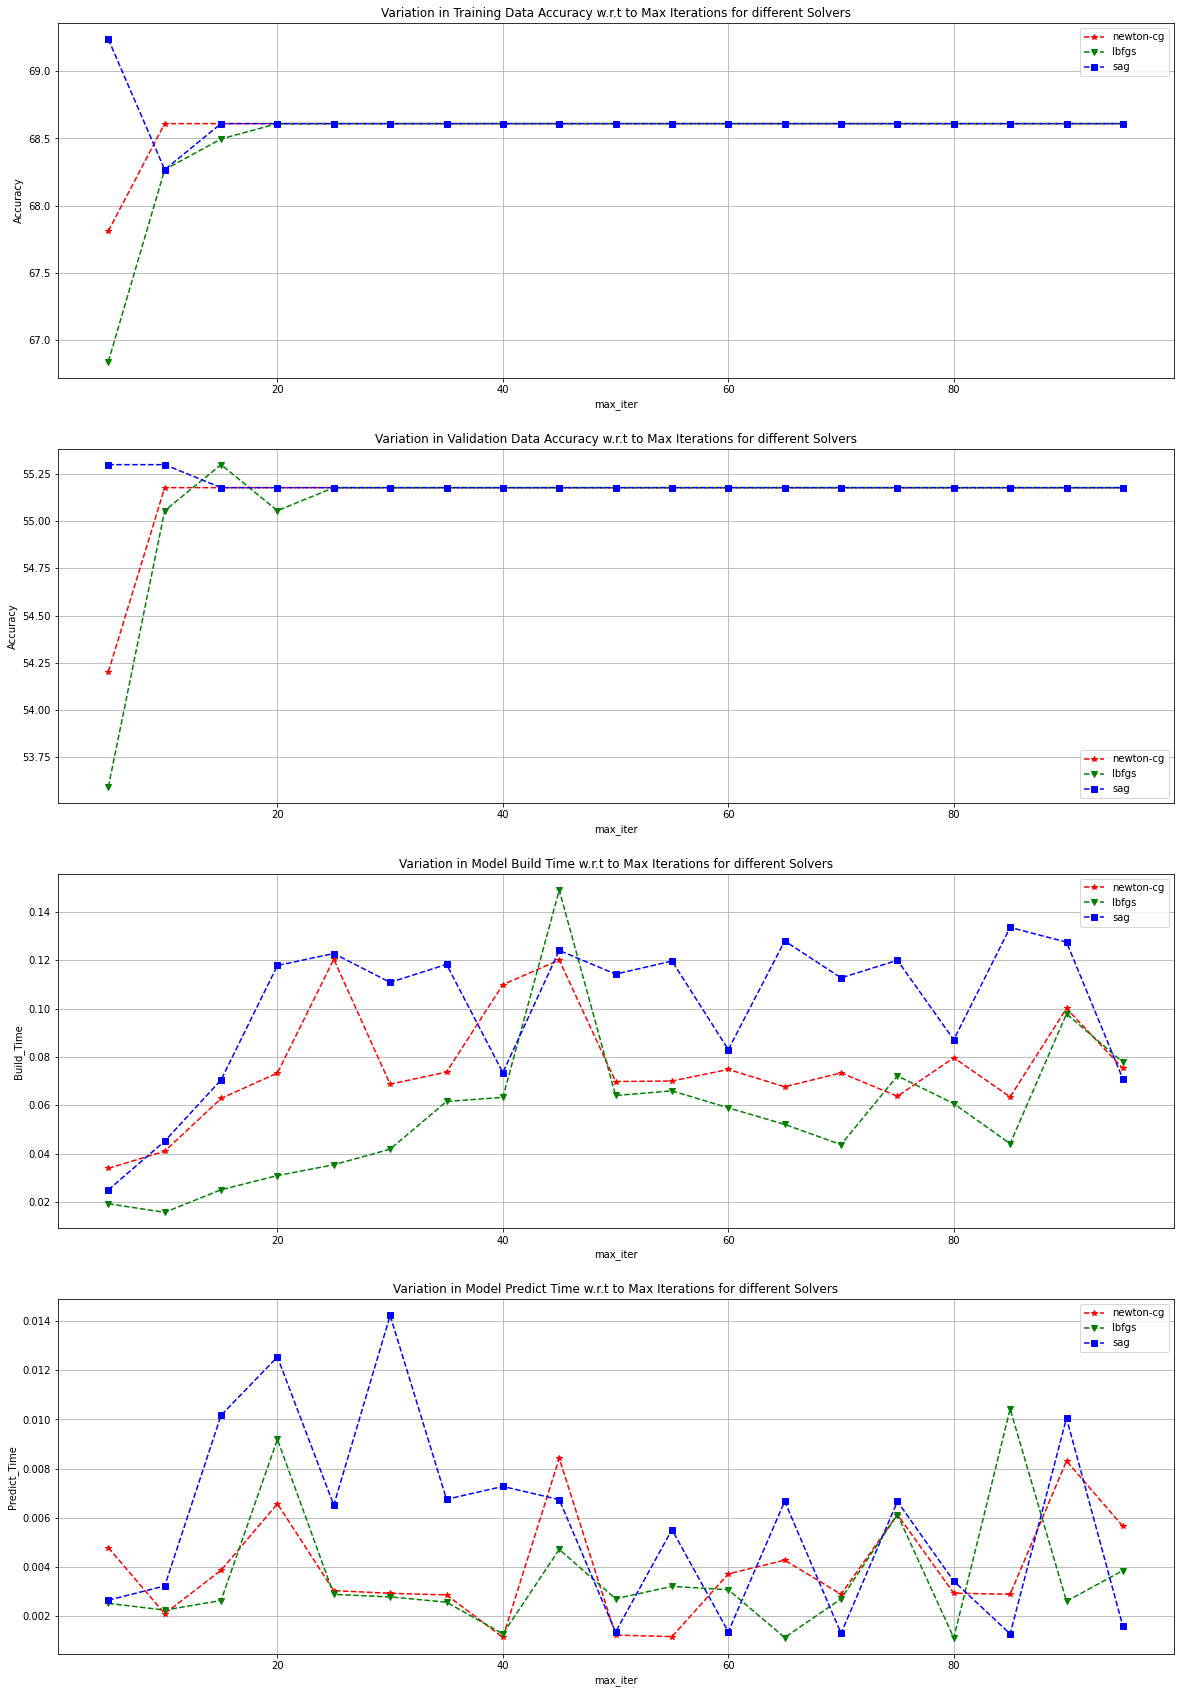

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(20,30))

ax[0].set(xlabel='max_iter', ylabel='Accuracy')
ax[0].set_title('Variation in Training Data Accuracy w.r.t to Max Iterations for different Solvers')
ax[0].grid(True)

colour_list = ['r*-','gv-','bs-']
for i in range(0,3):
    ax[0].plot(res_df_solver_max_iter['max_iter'],
               res_df_solver_max_iter['Train_acc_'+solver_list1[i]],
               colour_list[i]+'-', label=solver_list1[i])
ax[0].legend()

ax[1].set(xlabel='max_iter', ylabel='Accuracy')
ax[1].set_title('Variation in Validation Data Accuracy w.r.t to Max Iterations for different Solvers')
ax[1].grid(True)
for i in range(0,3):
    ax[1].plot(res_df_solver_max_iter['max_iter'],
               res_df_solver_max_iter['Val_acc_'+solver_list1[i]] ,
               colour_list[i]+'-', label=solver_list1[i])    
ax[1].legend()
    
ax[2].set(xlabel='max_iter', ylabel='Build_Time')
ax[2].set_title('Variation in Model Build Time w.r.t to Max Iterations for different Solvers')
ax[2].grid(True)
for i in range(0,3):
    ax[2].plot(res_df_solver_max_iter['max_iter'],
               res_df_solver_max_iter['Build_time_'+solver_list1[i]] ,
               colour_list[i]+'-', label=solver_list1[i])  
ax[2].legend()

ax[3].set(xlabel='max_iter', ylabel='Predict_Time')
ax[3].set_title('Variation in Model Predict Time w.r.t to Max Iterations for different Solvers')
ax[3].grid(True)
for i in range(0,3):
    ax[3].plot(res_df_solver_max_iter['max_iter'],
               res_df_solver_max_iter['Predict_time_'+solver_list1[i]] ,
               colour_list[i]+'-', label=solver_list1[i])  
ax[3].legend()

Оптимальное значение параметра max_iter = 25.

In [ ]:
C=0.001
iterations = 100
results2 = np.zeros((iterations, 18))
solver_list2 = ['newton-cg', 'lbfgs', 'sag', 'saga']

for i in trange(0, iterations):
  model_params2 = {'C':C, 'random_state':SEED, 'max_iter':25}
  results2[i][0:2] = i+1, C

  j = 2 #internal counter for iterating over each of the solver's results values
  for solver in solver_list2:
    model_params2.update({'solver': solver})
    LogReg = LogisticRegression()
    acc_train, acc_val, fit_time, predict_time, _ = evaluate_params(LogReg, x_train, y_train, x_val, y_val, model_params2)
    results2[i][j:j+4] = acc_train, acc_val, fit_time, predict_time
    j+=4
        
  C+=0.01

100%|██████████| 100/100 [00:21<00:00,  4.66it/s]


In [ ]:
columns2 = ['Sl','C']
for solver in solver_list2:
    columns2.append('Train_acc_'+solver)
    columns2.append('Val_acc_'+solver)
    columns2.append('Build_time_'+solver)
    columns2.append('Predict_time_'+solver)

res_df_solver_C = pd.DataFrame( data=results2[0:,0:], 
                                  index=results2[0:,0],
                                  columns=columns2)
res_df_solver_C['Sl'] = res_df_solver_C['Sl'].astype(np.uint16)
res_df_solver_C.head()

,Sl,C,Train_acc_newton-cg,Val_acc_newton-cg,Build_time_newton-cg,Predict_time_newton-cg,Train_acc_lbfgs,Val_acc_lbfgs,Build_time_lbfgs,Predict_time_lbfgs,Train_acc_sag,Val_acc_sag,Build_time_sag,Predict_time_sag,Train_acc_saga,Val_acc_saga,Build_time_saga,Predict_time_saga
1.0,1,0.001,60.663236,50.182704,0.019338,0.001134,60.663236,50.182704,0.005727,0.001059,60.663236,50.182704,0.035994,0.001270,60.663236,50.182704,0.045335,0.001291
2.0,2,0.011,60.663236,50.182704,0.016418,0.001076,60.663236,50.182704,0.007216,0.001007,60.663236,50.182704,0.043973,0.004920,60.663236,50.182704,0.045635,0.001243
3.0,3,0.021,61.177816,50.182704,0.018195,0.001085,61.177816,50.182704,0.006778,0.001086,61.177816,50.182704,0.029531,0.001273,61.177816,50.182704,0.046104,0.001244
4.0,4,0.031,61.978273,50.304507,0.016887,0.001084,61.978273,50.304507,0.007155,0.001029,61.978273,50.304507,0.036773,0.001278,61.978273,50.304507,0.047479,0.001263
5.0,5,0.041,63.121784,51.035323,0.019047,0.001198,63.121784,51.035323,0.008208,0.001085,63.121784,51.035323,0.035555,0.001259,63.121784,51.035323,0.045799,0.001252


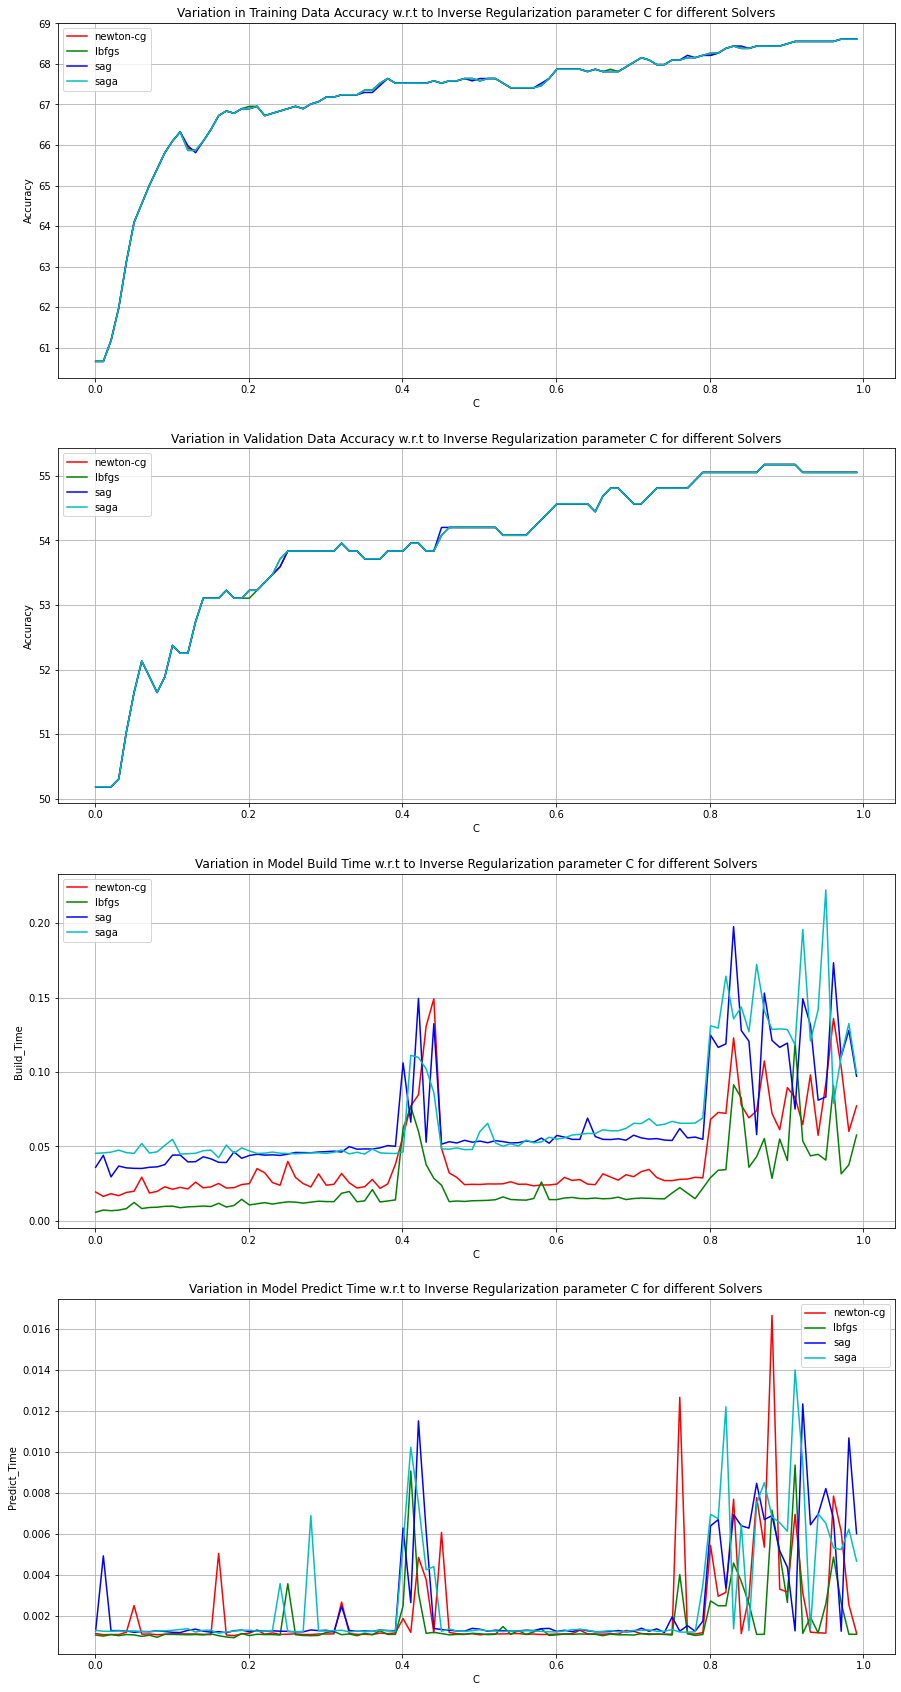

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15,30))

ax[0].set(xlabel='C', ylabel='Accuracy')
ax[0].set_title('Variation in Training Data Accuracy w.r.t to Inverse Regularization parameter C for different Solvers')
ax[0].grid(True)

colour_list = ['r','g','b','c']
for i in range(0,4):
    ax[0].plot(res_df_solver_C['C'],
               res_df_solver_C['Train_acc_'+solver_list2[i]],
               colour_list[i]+'-', label=solver_list2[i])
ax[0].legend()

ax[1].set(xlabel='C', ylabel='Accuracy')
ax[1].set_title('Variation in Validation Data Accuracy w.r.t to Inverse Regularization parameter C for different Solvers')
ax[1].grid(True)
for i in range(0,4):
    ax[1].plot(res_df_solver_C['C'],
               res_df_solver_C['Val_acc_'+solver_list2[i]] ,
               colour_list[i]+'-', label=solver_list2[i])    
ax[1].legend()

ax[2].set(xlabel='C', ylabel='Build_Time')
ax[2].set_title('Variation in Model Build Time w.r.t to Inverse Regularization parameter C for different Solvers')
ax[2].grid(True)
for i in range(0,4):
    ax[2].plot(res_df_solver_C['C'],
               res_df_solver_C['Build_time_'+solver_list2[i]] ,
               colour_list[i]+'-', label=solver_list2[i])  
ax[2].legend()

ax[3].set(xlabel='C', ylabel='Predict_Time')
ax[3].set_title('Variation in Model Predict Time w.r.t to Inverse Regularization parameter C for different Solvers')
ax[3].grid(True)
for i in range(0,4):
    ax[3].plot(res_df_solver_C['C'],
               res_df_solver_C['Predict_time_'+solver_list2[i]] ,
               colour_list[i]+'-', label=solver_list2[i])  
ax[3].legend()

In [ ]:
res=res_df_solver_C[res_df_solver_C['Val_acc_lbfgs'] == res_df_solver_C['Val_acc_lbfgs'].max()]
res[res['Train_acc_lbfgs'] == res['Train_acc_lbfgs'].max()]

,Sl,C,Train_acc_newton-cg,Val_acc_newton-cg,Build_time_newton-cg,Predict_time_newton-cg,Train_acc_lbfgs,Val_acc_lbfgs,Build_time_lbfgs,Predict_time_lbfgs,Train_acc_sag,Val_acc_sag,Build_time_sag,Predict_time_sag,Train_acc_saga,Val_acc_saga,Build_time_saga,Predict_time_saga
92.0,92,0.911,68.553459,55.176614,0.082832,0.006947,68.553459,55.176614,0.119633,0.009348,68.553459,55.176614,0.075061,0.001263,68.553459,55.176614,0.118212,0.013986


Оптимальное значение параметра C = 0.911.

In [ ]:
tol=1e-10
iterations = 30

results3 = np.zeros((iterations, 6))

for i in trange(0, iterations):    
  model_params3 = {'tol':tol,'random_state':SEED,'C':0.911, 'max_iter':25}
  results3[i][0:2] = i+1, tol
    
  j = 2 
  LogReg = LogisticRegression()
  acc_train, acc_val, fit_time, predict_time, _ = evaluate_params(LogReg, x_train, y_train, x_val, y_val, model_params3)
  results3[i][j:j+4] = acc_train, acc_val, fit_time, predict_time
        
  tol*=2

100%|██████████| 30/30 [00:00<00:00, 55.83it/s]


In [ ]:
columns3 = ['Sl','tol', 'Train_acc', 'Val_acc', 'Build_time', 'Predict_time']

res_df_tol = pd.DataFrame( data=results3[0:,0:], 
                                index=results3[0:,0],
                                columns=columns3)
res_df_tol['Sl'] = res_df_tol['Sl'].astype(np.uint16)
res_df_tol.head()

,Sl,tol,Train_acc,Val_acc,Build_time,Predict_time
1.0,1,1.000000e-10,68.553459,55.176614,0.024016,0.001154
2.0,2,2.000000e-10,68.553459,55.176614,0.015863,0.001110
3.0,3,4.000000e-10,68.553459,55.176614,0.015887,0.001116
4.0,4,8.000000e-10,68.553459,55.176614,0.017268,0.001171
5.0,5,1.600000e-09,68.553459,55.176614,0.015402,0.001118


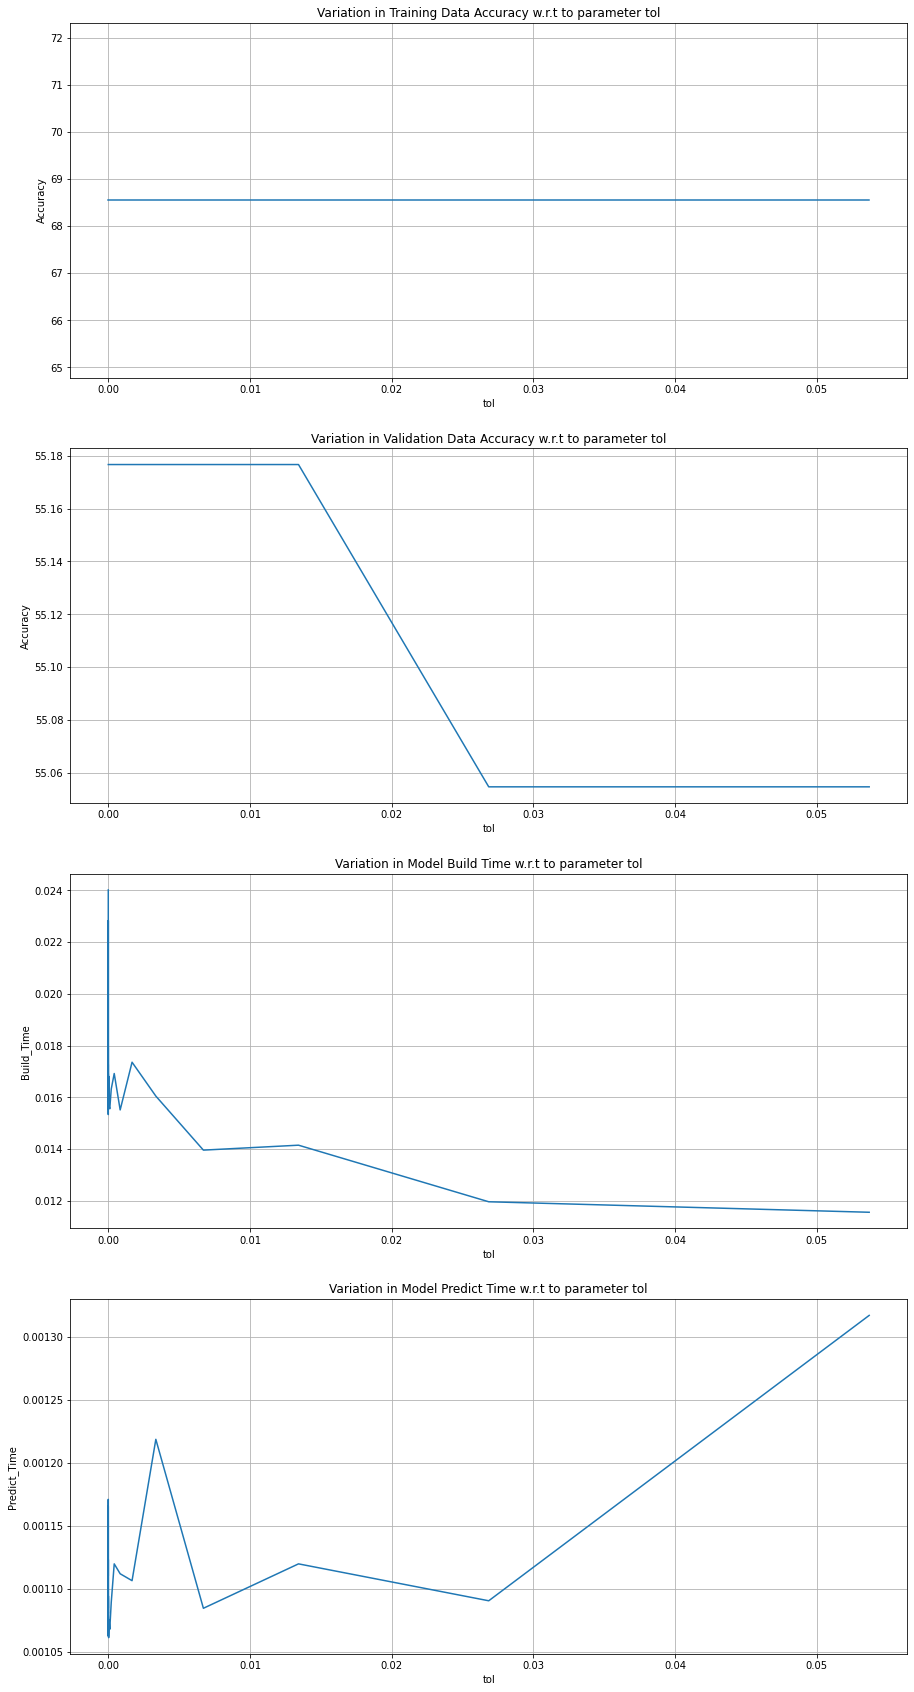

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15,30))

ax[0].set(xlabel='tol', ylabel='Accuracy')
ax[0].set_title('Variation in Training Data Accuracy w.r.t to parameter tol')
ax[0].grid(True)

ax[0].plot(res_df_tol['tol'],
           res_df_tol['Train_acc'],)

ax[1].set(xlabel='tol', ylabel='Accuracy')
ax[1].set_title('Variation in Validation Data Accuracy w.r.t to parameter tol')
ax[1].grid(True)
ax[1].plot(res_df_tol['tol'],
           res_df_tol['Val_acc'] ,) 

ax[2].set(xlabel='tol', ylabel='Build_Time')
ax[2].set_title('Variation in Model Build Time w.r.t to parameter tol')
ax[2].grid(True)
ax[2].plot(res_df_tol['tol'],
           res_df_tol['Build_time']) 

ax[3].set(xlabel='tol', ylabel='Predict_Time')
ax[3].set_title('Variation in Model Predict Time w.r.t to parameter tol')
ax[3].grid(True)
ax[3].plot(res_df_tol['tol'],
           res_df_tol['Predict_time'])  

In [ ]:
res=res_df_tol[res_df_tol['Val_acc'] == res_df_tol['Val_acc'].max()]
res[res['Train_acc'] == res['Train_acc'].max()]

,Sl,tol,Train_acc,Val_acc,Build_time,Predict_time
1.0,1,1.000000e-10,68.553459,55.176614,0.024016,0.001154
2.0,2,2.000000e-10,68.553459,55.176614,0.015863,0.001110
3.0,3,4.000000e-10,68.553459,55.176614,0.015887,0.001116
4.0,4,8.000000e-10,68.553459,55.176614,0.017268,0.001171
5.0,5,1.600000e-09,68.553459,55.176614,0.015402,0.001118
6.0,6,3.200000e-09,68.553459,55.176614,0.015333,0.001094
7.0,7,6.400000e-09,68.553459,55.176614,0.017923,0.001123
8.0,8,1.280000e-08,68.553459,55.176614,0.016426,0.001085
9.0,9,2.560000e-08,68.553459,55.176614,0.015823,0.001123
10.0,10,5.120000e-08,68.553459,55.176614,0.016110,0.001098


Следовательно, оптимальные значения параметра tol находятся в интервале \[1e-10, 1.34e-2\].

In [ ]:
LogReg = LogisticRegression(tol=1e-10, C=0.911, max_iter=25)
LogReg.fit(x_train, y_train)

LogisticRegression(C=0.911, max_iter=25, tol=1e-10)

In [ ]:
# Тестирование модели на валидационной выборке и вывод оценок ее точности
pred = LogReg.predict(x_val)
print(classification_report(y_val, pred))
print('Accuracy:', accuracy_score(y_val, pred))

              precision    recall  f1-score   support

       False       0.69      0.18      0.29       409
        True       0.53      0.92      0.67       412

    accuracy                           0.55       821
   macro avg       0.61      0.55      0.48       821
weighted avg       0.61      0.55      0.48       821

Accuracy: 0.5517661388550548


In [ ]:
# Тестирование модели на тестовой выборке и вывод оценок ее точности
pred = LogReg.predict(x_test)
print(classification_report(y_test, pred))
print('Accuracy:', accuracy_score(y_test, pred))

              precision    recall  f1-score   support

       False       0.63      0.17      0.27       210
        True       0.49      0.89      0.63       190

    accuracy                           0.51       400
   macro avg       0.56      0.53      0.45       400
weighted avg       0.57      0.51      0.44       400

Accuracy: 0.5125


## Обучение Logistic Regression на предобученных эмбеддингах GLOVE

Оптимизация параметра max_iter.

In [ ]:
max_iter=5
iterations = 19

# Есть 3 решателя. Для каждого из них нам нужно увидеть их точность в наборах для обучения и проверки, а также время их сборки.
# Дополнительно, первые два столбца - это Sl и max_iter. Следовательно, всего требуется (3 * 4) + 2 = 14 столбцов.
results = np.zeros((iterations, 14))
solver_list1 = ['newton-cg', 'lbfgs', 'sag']

for i in trange(0,iterations):    
    model_params1 = {'max_iter':max_iter,'random_state':SEED}
    results[i][0:2] = i+1, max_iter
    
    j = 2 
    for solver in solver_list1:
        model_params1.update({'solver': solver})
        LogReg=LogisticRegression()
        acc_train, acc_val, fit_time, predict_time, _ = evaluate_params(LogReg, x_train_glove, y_train, x_val_glove, y_val, model_params1)
        results[i][j:j+4] = acc_train, acc_val, fit_time, predict_time
        j+=4
        
    max_iter += 5


100%|██████████| 19/19 [00:03<00:00,  4.77it/s]


In [ ]:
columns = ['Sl','max_iter']
for solver in solver_list1:
    columns.append('Train_acc_'+solver)
    columns.append('Val_acc_'+solver)
    columns.append('Build_time_'+solver)
    columns.append('Predict_time_'+solver)

res_df_solver_max_iter = pd.DataFrame( data=results[0:,0:], 
                                  index=results[0:,0],
                                  columns=columns)
res_df_solver_max_iter['Sl'] = res_df_solver_max_iter['Sl'].astype(np.uint16)
res_df_solver_max_iter.head()

,Sl,max_iter,Train_acc_newton-cg,Val_acc_newton-cg,Build_time_newton-cg,Predict_time_newton-cg,Train_acc_lbfgs,Val_acc_lbfgs,Build_time_lbfgs,Predict_time_lbfgs,Train_acc_sag,Val_acc_sag,Build_time_sag,Predict_time_sag
1.0,1,5.0,70.954831,52.984166,0.021608,0.001382,67.409949,53.227771,0.006637,0.001298,70.726129,53.593179,0.029388,0.001461
2.0,2,10.0,71.126358,52.496955,0.036133,0.001298,71.355060,52.375152,0.009518,0.001285,71.126358,52.618758,0.057996,0.001546
3.0,3,15.0,71.126358,52.496955,0.048017,0.001355,70.840480,52.862363,0.012021,0.001303,71.126358,52.496955,0.089536,0.001554
4.0,4,20.0,71.126358,52.496955,0.058161,0.001523,71.183533,52.375152,0.016082,0.001363,71.183533,52.496955,0.122432,0.001807
5.0,5,25.0,71.126358,52.496955,0.057226,0.001516,71.183533,52.496955,0.018034,0.001306,71.126358,52.496955,0.137966,0.001868


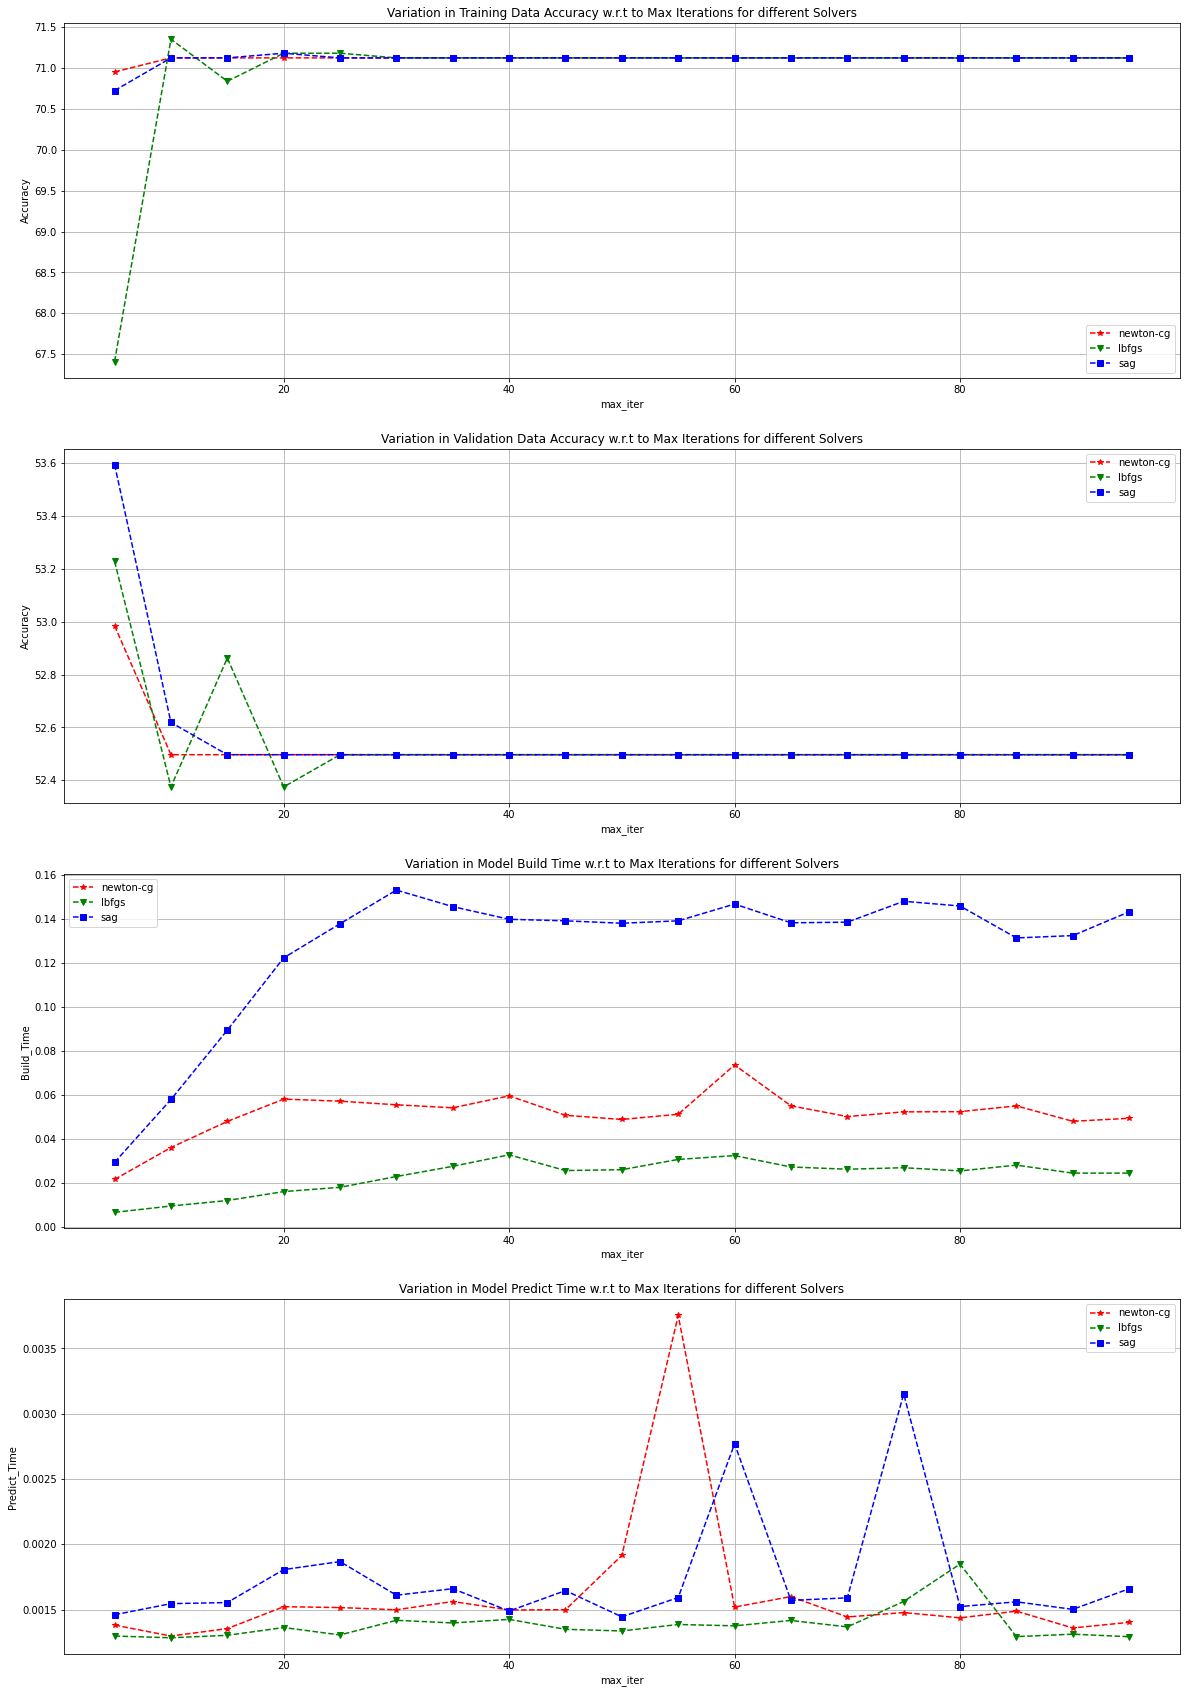

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(20,30))

ax[0].set(xlabel='max_iter', ylabel='Accuracy')
ax[0].set_title('Variation in Training Data Accuracy w.r.t to Max Iterations for different Solvers')
ax[0].grid(True)

colour_list = ['r*-','gv-','bs-']
for i in range(0,3):
    ax[0].plot(res_df_solver_max_iter['max_iter'],
               res_df_solver_max_iter['Train_acc_'+solver_list1[i]],
               colour_list[i]+'-', label=solver_list1[i])
ax[0].legend()

ax[1].set(xlabel='max_iter', ylabel='Accuracy')
ax[1].set_title('Variation in Validation Data Accuracy w.r.t to Max Iterations for different Solvers')
ax[1].grid(True)
for i in range(0,3):
    ax[1].plot(res_df_solver_max_iter['max_iter'],
               res_df_solver_max_iter['Val_acc_'+solver_list1[i]] ,
               colour_list[i]+'-', label=solver_list1[i])    
ax[1].legend()
    
ax[2].set(xlabel='max_iter', ylabel='Build_Time')
ax[2].set_title('Variation in Model Build Time w.r.t to Max Iterations for different Solvers')
ax[2].grid(True)
for i in range(0,3):
    ax[2].plot(res_df_solver_max_iter['max_iter'],
               res_df_solver_max_iter['Build_time_'+solver_list1[i]] ,
               colour_list[i]+'-', label=solver_list1[i])  
ax[2].legend()

ax[3].set(xlabel='max_iter', ylabel='Predict_Time')
ax[3].set_title('Variation in Model Predict Time w.r.t to Max Iterations for different Solvers')
ax[3].grid(True)
for i in range(0,3):
    ax[3].plot(res_df_solver_max_iter['max_iter'],
               res_df_solver_max_iter['Predict_time_'+solver_list1[i]] ,
               colour_list[i]+'-', label=solver_list1[i])  
ax[3].legend()

Оптимальное значение параметра max_iter = 30.

In [ ]:
C=0.001
iterations = 100
results2 = np.zeros((iterations, 18))
solver_list2 = ['newton-cg', 'lbfgs', 'sag', 'saga']

for i in trange(0, iterations):
  model_params2 = {'C':C, 'random_state':SEED, 'max_iter':30}
  results2[i][0:2] = i+1, C

  j = 2 #internal counter for iterating over each of the solver's results values
  for solver in solver_list2:
    model_params2.update({'solver': solver})
    LogReg = LogisticRegression()
    acc_train, acc_val, fit_time, predict_time, _ = evaluate_params(LogReg, x_train_glove, y_train, x_val_glove, y_val, model_params2)
    results2[i][j:j+4] = acc_train, acc_val, fit_time, predict_time
    j+=4
        
  C+=0.01

100%|██████████| 100/100 [00:41<00:00,  2.43it/s]


In [ ]:
columns2 = ['Sl','C']
for solver in solver_list2:
    columns2.append('Train_acc_'+solver)
    columns2.append('Val_acc_'+solver)
    columns2.append('Build_time_'+solver)
    columns2.append('Predict_time_'+solver)

res_df_solver_C = pd.DataFrame( data=results2[0:,0:], 
                                  index=results2[0:,0],
                                  columns=columns2)
res_df_solver_C['Sl'] = res_df_solver_C['Sl'].astype(np.uint16)
res_df_solver_C.head()

,Sl,C,Train_acc_newton-cg,Val_acc_newton-cg,Build_time_newton-cg,Predict_time_newton-cg,Train_acc_lbfgs,Val_acc_lbfgs,Build_time_lbfgs,Predict_time_lbfgs,Train_acc_sag,Val_acc_sag,Build_time_sag,Predict_time_sag,Train_acc_saga,Val_acc_saga,Build_time_saga,Predict_time_saga
1.0,1,0.001,60.663236,50.182704,0.169048,0.010415,60.663236,50.182704,0.023368,0.013252,60.663236,50.182704,0.179708,0.007228,60.663236,50.182704,0.227354,0.001604
2.0,2,0.011,61.635220,49.817296,0.072163,0.007629,61.635220,49.817296,0.027159,0.016940,61.635220,49.817296,0.164306,0.001898,61.635220,49.817296,0.136926,0.007878
3.0,3,0.021,62.664380,50.060901,0.114656,0.006274,62.664380,50.060901,0.018807,0.001374,62.664380,50.060901,0.103140,0.010301,62.664380,50.060901,0.143893,0.007358
4.0,4,0.031,63.865066,50.669915,0.096255,0.005811,63.865066,50.669915,0.026601,0.003309,63.865066,50.669915,0.164657,0.006913,63.865066,50.669915,0.191862,0.006948
5.0,5,0.041,65.122927,51.035323,0.086460,0.001552,65.122927,51.035323,0.029730,0.001710,65.122927,51.035323,0.133467,0.001662,65.122927,51.035323,0.125537,0.001737


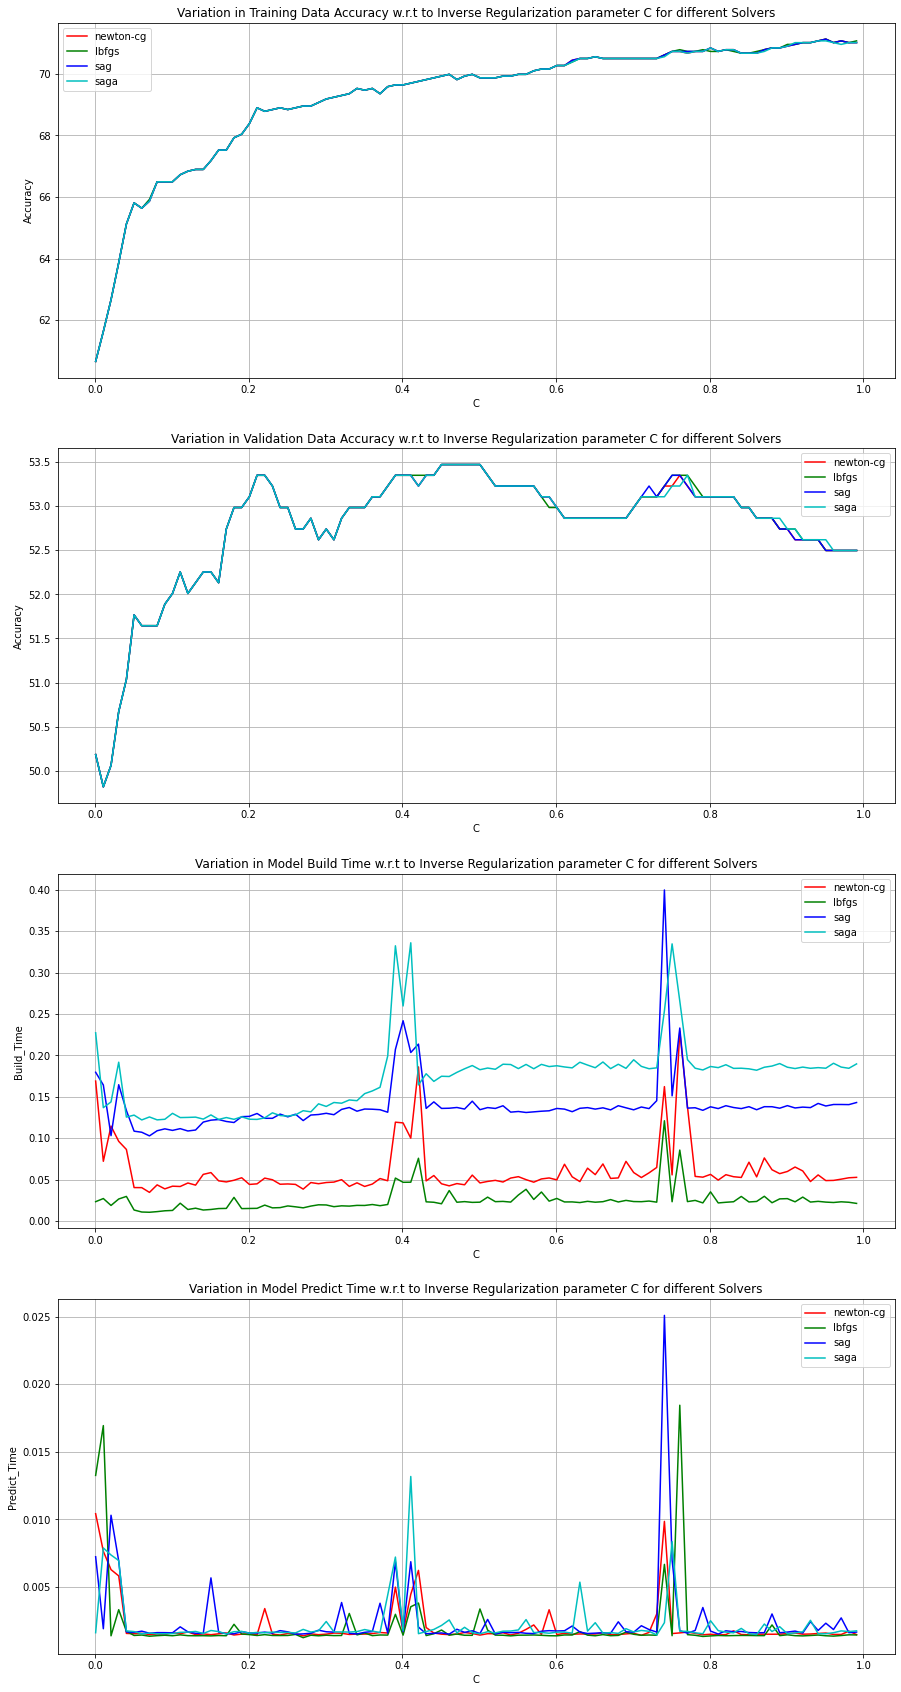

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15,30))

ax[0].set(xlabel='C', ylabel='Accuracy')
ax[0].set_title('Variation in Training Data Accuracy w.r.t to Inverse Regularization parameter C for different Solvers')
ax[0].grid(True)

colour_list = ['r','g','b','c']
for i in range(0,4):
    ax[0].plot(res_df_solver_C['C'],
               res_df_solver_C['Train_acc_'+solver_list2[i]],
               colour_list[i]+'-', label=solver_list2[i])
ax[0].legend()

ax[1].set(xlabel='C', ylabel='Accuracy')
ax[1].set_title('Variation in Validation Data Accuracy w.r.t to Inverse Regularization parameter C for different Solvers')
ax[1].grid(True)
for i in range(0,4):
    ax[1].plot(res_df_solver_C['C'],
               res_df_solver_C['Val_acc_'+solver_list2[i]] ,
               colour_list[i]+'-', label=solver_list2[i])    
ax[1].legend()

ax[2].set(xlabel='C', ylabel='Build_Time')
ax[2].set_title('Variation in Model Build Time w.r.t to Inverse Regularization parameter C for different Solvers')
ax[2].grid(True)
for i in range(0,4):
    ax[2].plot(res_df_solver_C['C'],
               res_df_solver_C['Build_time_'+solver_list2[i]] ,
               colour_list[i]+'-', label=solver_list2[i])  
ax[2].legend()

ax[3].set(xlabel='C', ylabel='Predict_Time')
ax[3].set_title('Variation in Model Predict Time w.r.t to Inverse Regularization parameter C for different Solvers')
ax[3].grid(True)
for i in range(0,4):
    ax[3].plot(res_df_solver_C['C'],
               res_df_solver_C['Predict_time_'+solver_list2[i]] ,
               colour_list[i]+'-', label=solver_list2[i])  
ax[3].legend()

In [ ]:
res=res_df_solver_C[res_df_solver_C['Val_acc_saga'] == res_df_solver_C['Val_acc_saga'].max()]
res[res['Train_acc_saga'] == res['Train_acc_saga'].max()]

,Sl,C,Train_acc_newton-cg,Val_acc_newton-cg,Build_time_newton-cg,Predict_time_newton-cg,Train_acc_lbfgs,Val_acc_lbfgs,Build_time_lbfgs,Predict_time_lbfgs,Train_acc_sag,Val_acc_sag,Build_time_sag,Predict_time_sag,Train_acc_saga,Val_acc_saga,Build_time_saga,Predict_time_saga
47.0,47,0.461,69.982847,53.471376,0.042500,0.001461,69.982847,53.471376,0.036820,0.001421,69.982847,53.471376,0.136259,0.001500,69.982847,53.471376,0.174587,0.002550
50.0,50,0.491,69.982847,53.471376,0.055474,0.001545,69.982847,53.471376,0.022525,0.001410,69.982847,53.471376,0.144782,0.001747,69.982847,53.471376,0.187828,0.001608


In [ ]:
res=res_df_solver_C[res_df_solver_C['Val_acc_lbfgs'] == res_df_solver_C['Val_acc_lbfgs'].max()]
res[res['Train_acc_lbfgs'] == res['Train_acc_lbfgs'].max()]

,Sl,C,Train_acc_newton-cg,Val_acc_newton-cg,Build_time_newton-cg,Predict_time_newton-cg,Train_acc_lbfgs,Val_acc_lbfgs,Build_time_lbfgs,Predict_time_lbfgs,Train_acc_sag,Val_acc_sag,Build_time_sag,Predict_time_sag,Train_acc_saga,Val_acc_saga,Build_time_saga,Predict_time_saga
47.0,47,0.461,69.982847,53.471376,0.042500,0.001461,69.982847,53.471376,0.036820,0.001421,69.982847,53.471376,0.136259,0.001500,69.982847,53.471376,0.174587,0.002550
50.0,50,0.491,69.982847,53.471376,0.055474,0.001545,69.982847,53.471376,0.022525,0.001410,69.982847,53.471376,0.144782,0.001747,69.982847,53.471376,0.187828,0.001608


Таким образом, оптимальные значения параметра C: 0.461, 0.491.

In [ ]:
tol=1e-10
iterations = 30

results3 = np.zeros((iterations, 6))

for i in trange(0, iterations):    
  model_params3 = {'tol':tol,'random_state':SEED,'C':0.461, 'max_iter':30}
  results3[i][0:2] = i+1, tol
    
  j = 2 
  LogReg = LogisticRegression()
  acc_train, acc_val, fit_time, predict_time, _ = evaluate_params(LogReg, x_train_glove, y_train, x_val_glove, y_val, model_params3)
  results3[i][j:j+4] = acc_train, acc_val, fit_time, predict_time
        
  tol*=2

100%|██████████| 30/30 [00:01<00:00, 21.19it/s]


In [ ]:
columns3 = ['Sl','tol', 'Train_acc', 'Val_acc', 'Build_time', 'Predict_time']

res_df_tol = pd.DataFrame( data=results3[0:,0:], 
                                index=results3[0:,0],
                                columns=columns3)
res_df_tol['Sl'] = res_df_tol['Sl'].astype(np.uint16)
res_df_tol.head()

,Sl,tol,Train_acc,Val_acc,Build_time,Predict_time
1.0,1,1.000000e-10,69.982847,53.471376,0.045644,0.002348
2.0,2,2.000000e-10,69.982847,53.471376,0.044894,0.003469
3.0,3,4.000000e-10,69.982847,53.471376,0.060505,0.001425
4.0,4,8.000000e-10,69.982847,53.471376,0.046809,0.005548
5.0,5,1.600000e-09,69.982847,53.471376,0.046592,0.005011


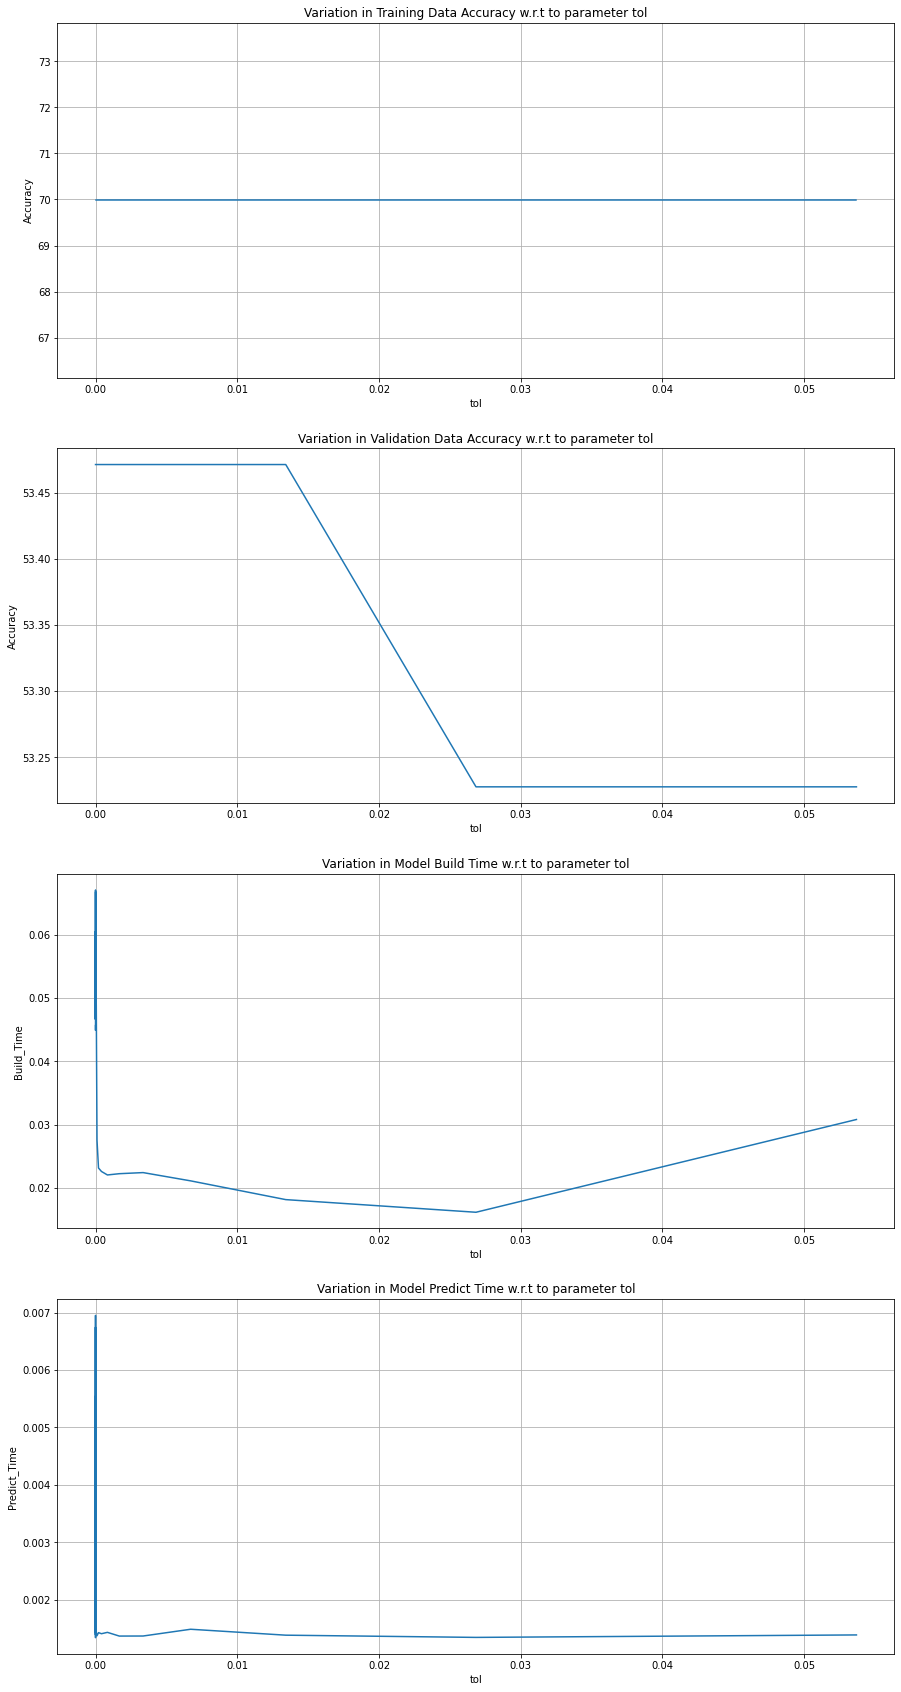

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15,30))

ax[0].set(xlabel='tol', ylabel='Accuracy')
ax[0].set_title('Variation in Training Data Accuracy w.r.t to parameter tol')
ax[0].grid(True)

ax[0].plot(res_df_tol['tol'],
           res_df_tol['Train_acc'],)

ax[1].set(xlabel='tol', ylabel='Accuracy')
ax[1].set_title('Variation in Validation Data Accuracy w.r.t to parameter tol')
ax[1].grid(True)
ax[1].plot(res_df_tol['tol'],
           res_df_tol['Val_acc'] ,) 

ax[2].set(xlabel='tol', ylabel='Build_Time')
ax[2].set_title('Variation in Model Build Time w.r.t to parameter tol')
ax[2].grid(True)
ax[2].plot(res_df_tol['tol'],
           res_df_tol['Build_time']) 

ax[3].set(xlabel='tol', ylabel='Predict_Time')
ax[3].set_title('Variation in Model Predict Time w.r.t to parameter tol')
ax[3].grid(True)
ax[3].plot(res_df_tol['tol'],
           res_df_tol['Predict_time'])  

In [ ]:
res=res_df_tol[res_df_tol['Val_acc'] == res_df_tol['Val_acc'].max()]
res[res['Train_acc'] == res['Train_acc'].max()]

,Sl,tol,Train_acc,Val_acc,Build_time,Predict_time
1.0,1,1.000000e-10,69.982847,53.471376,0.045644,0.002348
2.0,2,2.000000e-10,69.982847,53.471376,0.044894,0.003469
3.0,3,4.000000e-10,69.982847,53.471376,0.060505,0.001425
4.0,4,8.000000e-10,69.982847,53.471376,0.046809,0.005548
5.0,5,1.600000e-09,69.982847,53.471376,0.046592,0.005011
6.0,6,3.200000e-09,69.982847,53.471376,0.048679,0.001389
7.0,7,6.400000e-09,69.982847,53.471376,0.067046,0.003213
8.0,8,1.280000e-08,69.982847,53.471376,0.049077,0.003635
9.0,9,2.560000e-08,69.982847,53.471376,0.050689,0.002990
10.0,10,5.120000e-08,69.982847,53.471376,0.051934,0.006747


Оптимальное значение параметра tol находится в интервале \[1e-10, 1.34e-2\].

In [ ]:
LogReg = LogisticRegression(tol=1e-2, C=0.461, max_iter=30)
LogReg.fit(x_train_glove, y_train)

LogisticRegression(C=0.461, max_iter=30, tol=0.01)

In [ ]:
# Тестирование модели на валидационной выборке и вывод оценок ее точности
pred = LogReg.predict(x_val_glove)
print(classification_report(y_val, pred))
print('Accuracy:', accuracy_score(y_val, pred))

              precision    recall  f1-score   support

       False       0.63      0.16      0.26       409
        True       0.52      0.90      0.66       412

    accuracy                           0.53       821
   macro avg       0.57      0.53      0.46       821
weighted avg       0.57      0.53      0.46       821

Accuracy: 0.5347137637028014


In [ ]:
# Тестирование модели на тестовой выборке и вывод оценок ее точности
pred = LogReg.predict(x_test_glove)
print(classification_report(y_test, pred))
print('Accuracy:', accuracy_score(y_test, pred))

              precision    recall  f1-score   support

       False       0.64      0.18      0.28       210
        True       0.49      0.89      0.64       190

    accuracy                           0.52       400
   macro avg       0.57      0.53      0.46       400
weighted avg       0.57      0.52      0.45       400

Accuracy: 0.515


## Обучение KNN на предобученных эмбеддингах Word2vec

Подбор оптимального значения параметра n_neighbors

In [ ]:
n_neighbors = 1
iterations = 40
results = np.zeros((iterations, 6))

for i in trange(0, iterations):
  model_params = {'n_neighbors':n_neighbors}
  KNN = KNeighborsClassifier()
  acc_train, acc_val, fit_time, predict_time, _ = evaluate_params(KNN, x_train, y_train, x_val, y_val, model_params)
  results[i] = i+1, n_neighbors, acc_train, acc_val, fit_time, predict_time
  n_neighbors += 1


100%|██████████| 40/40 [00:09<00:00,  4.24it/s]


In [ ]:
res_df = pd.DataFrame(  data=results[0:,0:], 
                        index=results[0:,0],
                        columns=['Sl','n_neighbors','Train_acc','Val_acc', 'Build_time', 'Predict_time'])
res_df['Sl'] = res_df['Sl'].astype(np.uint16)
res_df.head()

,Sl,n_neighbors,Train_acc,Val_acc,Build_time,Predict_time
1.0,1,1.0,100.000000,52.862363,0.000839,0.503664
2.0,2,2.0,84.562607,55.663825,0.000872,0.215283
3.0,3,3.0,82.447113,54.567600,0.000764,0.257847
4.0,4,4.0,79.645512,54.811206,0.000805,0.240411
5.0,5,5.0,77.644368,54.202192,0.000821,0.243582


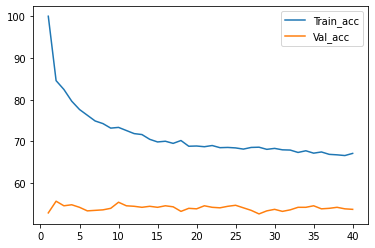

In [ ]:
# Построение графика значений точности на обучающей и валидационной выборках в зависимости от значения n_neighbors
fig, ax = plt.subplots()
ax.plot(res_df['n_neighbors'], res_df['Train_acc'], label='Train_acc')
ax.plot(res_df['n_neighbors'], res_df['Val_acc'], label='Val_acc')
ax.legend().set_visible(True)

In [ ]:
# Поиск значения n_neighbors & Val_acc, при котором точность набора проверки максимальна.
res_df[res_df['Val_acc'] == res_df['Val_acc'].max()]

,Sl,n_neighbors,Train_acc,Val_acc,Build_time,Predict_time
2.0,2,2.0,84.562607,55.663825,0.000872,0.215283


Таким образом, оптимальное значение n_neighbors=2.

In [ ]:
# Обучение модели с найденным параметром n_neighbors
KNN = KNeighborsClassifier(n_neighbors=2)
KNN.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [ ]:
# Тестирование модели на валидационной выборке и вывод оценок ее точности
pred = KNN.predict(x_val)
print(classification_report(y_val, pred))
print('Accuracy:', accuracy_score(y_val, pred))

              precision    recall  f1-score   support

       False       0.56      0.52      0.54       409
        True       0.55      0.59      0.57       412

    accuracy                           0.56       821
   macro avg       0.56      0.56      0.56       821
weighted avg       0.56      0.56      0.56       821

Accuracy: 0.5566382460414129


In [ ]:
# Тестирование модели на тестовой выборке и вывод оценок ее точности
pred = KNN.predict(x_test)
print(classification_report(y_test, pred))
print('Accuracy:', accuracy_score(y_test, pred))

              precision    recall  f1-score   support

       False       0.53      0.52      0.53       210
        True       0.48      0.49      0.49       190

    accuracy                           0.51       400
   macro avg       0.51      0.51      0.51       400
weighted avg       0.51      0.51      0.51       400

Accuracy: 0.5075


## Обучение KNN на предобученных эмбеддингах GLOVE

Подбор оптимального значения параметра n_neighbors

In [ ]:
n_neighbors = 1
iterations = 40
results = np.zeros((iterations, 6))

for i in trange(0, iterations):
  model_params = {'n_neighbors':n_neighbors}
  KNN = KNeighborsClassifier()
  acc_train, acc_val, fit_time, predict_time, _ = evaluate_params(KNN, x_train_glove, y_train, x_val_glove, y_val, model_params)
  results[i] = i+1, n_neighbors, acc_train, acc_val, fit_time, predict_time
  n_neighbors += 1


100%|██████████| 40/40 [00:11<00:00,  3.50it/s]


In [ ]:
res_df = pd.DataFrame(  data=results[0:,0:], 
                        index=results[0:,0],
                        columns=['Sl','n_neighbors','Train_acc','Val_acc', 'Build_time', 'Predict_time'])
res_df['Sl'] = res_df['Sl'].astype(np.uint16)
res_df.head()

,Sl,n_neighbors,Train_acc,Val_acc,Build_time,Predict_time
1.0,1,1.0,99.942824,54.811206,0.000987,0.170081
2.0,2,2.0,86.163522,52.375152,0.000894,0.179724
3.0,3,3.0,83.476272,53.958587,0.000873,0.192309
4.0,4,4.0,79.473985,51.644336,0.001050,0.203139
5.0,5,5.0,77.358491,52.009744,0.000823,0.218274


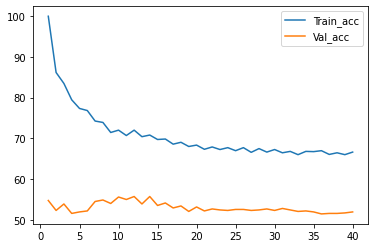

In [ ]:
# Построение графика значений точности на обучающей и валидационной выборках в зависимости от значения n_neighbors
fig, ax = plt.subplots()
ax.plot(res_df['n_neighbors'], res_df['Train_acc'], label='Train_acc')
ax.plot(res_df['n_neighbors'], res_df['Val_acc'], label='Val_acc')
ax.legend().set_visible(True)

In [ ]:
# Поиск значения n_neighbors & Val_acc, при котором точность набора проверки максимальна.
res_df[res_df['Val_acc'] == res_df['Val_acc'].max()]

,Sl,n_neighbors,Train_acc,Val_acc,Build_time,Predict_time
12.0,12,12.0,72.041166,55.785627,0.000989,0.513526
14.0,14,14.0,70.840480,55.785627,0.000928,0.386995


Таким образом, оптимальное значение n_neighbors=12.

In [ ]:
# Обучение модели с найденным параметром n_neighbors
KNN = KNeighborsClassifier(n_neighbors=12)
KNN.fit(x_train_glove, y_train)

KNeighborsClassifier(n_neighbors=12)

In [ ]:
# Тестирование модели на валидационной выборке и вывод оценок ее точности
pred = KNN.predict(x_val_glove)
print(classification_report(y_val, pred))
print('Accuracy:', accuracy_score(y_val, pred))

              precision    recall  f1-score   support

       False       0.66      0.23      0.34       409
        True       0.54      0.89      0.67       412

    accuracy                           0.56       821
   macro avg       0.60      0.56      0.50       821
weighted avg       0.60      0.56      0.50       821

Accuracy: 0.5578562728380024


In [ ]:
# Тестирование модели на тестовой выборке и вывод оценок ее точности
pred = KNN.predict(x_test_glove)
print(classification_report(y_test, pred))
print('Accuracy:', accuracy_score(y_test, pred))

              precision    recall  f1-score   support

       False       0.59      0.22      0.33       210
        True       0.49      0.83      0.62       190

    accuracy                           0.51       400
   macro avg       0.54      0.53      0.47       400
weighted avg       0.55      0.51      0.46       400

Accuracy: 0.5125


## Рассмотрение бенчмарка RussianSuperGLUE 

In [ ]:
!pip install overrides==3.1.0
!pip install allennlp===0.9.0
!pip install jsondiff
!pip install pyhocon
!pip install python-Levenshtein

In [ ]:
# Переход в папку, куда сохраним папку с бенчмарком RussianSuperGLUE
os.chdir(path_to_dir)

In [ ]:
# Загрузка папки с бенчмарком
!git clone 'https://github.com/RussianNLP/RussianSuperGLUE.git'

Cloning into 'RussianSuperGLUE'...
remote: Enumerating objects: 467, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 467 (delta 0), reused 0 (delta 0), pack-reused 462
Receiving objects: 100% (467/467), 15.95 MiB | 7.85 MiB/s, done.
Resolving deltas: 100% (132/132), done.
Checking out files: 100% (330/330), done.


In [ ]:
# Переход в директорию RussianSuperGLUE/jiant-russian-v2/, в которой находятся необходимые папки и файлы для запуска бенчмарка
os.chdir('./RussianSuperGLUE/jiant-russian-v2/')

In [ ]:
# Задаем права доступа на файл, чтобы запустить его дальше для задачи DaNetQA
!chmod 755 './scripts/russian-superglue-baselines.sh'

In [ ]:
# Запуск лучшей модели бенчмарка RussianSuperGLUE для обучения её на данных DaNetQA
! './scripts/russian-superglue-baselines.sh' 'danetqa'

In [ ]:
# Вывод полученных результатов оценки модели на валидационной выборке
print(open('./model_dir/rubert-conversational/results.tsv').readlines())

['danetqa\tmicro_avg: 0.654, macro_avg: 0.654, danetqa_acc_f1: 0.654, danetqa_accuracy: 0.607, danetqa_f1: 0.701, danetqa_precision: 0.567, danetqa_recall: 0.917\n']


## Conversational RuBERT

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer 

# Define the model repo
model_name ='DeepPavlov/rubert-base-cased-conversational'

# Download bert tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name)

In [ ]:
# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)
print(device)

cuda


In [ ]:
def predict(model, inputs, masks):
  model.eval()
  inputs=inputs.to(device)
  masks=masks.to(device)
  with torch.no_grad():
    # Forward pass, рассчитать логит-прогнозы
    logits = model(inputs, token_type_ids=None, attention_mask=masks)    
  # Переместить logits и labels на CPU
  logits = logits[0].detach().cpu().numpy()
  return logits

### Дообучение модели RuBERT и оптимизация её гиперпараметров

Получение токенов для текста.

In [ ]:
encoded_sequences = list(map(lambda q, p: tokenizer.encode_plus(q, p, max_length=100, pad_to_max_length=True, return_attention_mask = True), questions, passages))

In [ ]:
test_encoded_sequences = list(map(lambda q, p: tokenizer.encode_plus(q, p, max_length=100, pad_to_max_length=True, return_attention_mask = True), test_questions, test_passages))

In [ ]:
test_encoded_sequences[0]

{'input_ids': [101, 20177, 942, 36312, 801, 27369, 166, 102, 1271, 88824, 4313, 76178, 347, 65984, 29631, 340, 12310, 9202, 1630, 88223, 28707, 879, 1725, 897, 8380, 444, 54735, 48115, 132, 7290, 802, 10008, 22353, 949, 1757, 128, 876, 50134, 6947, 130, 37272, 52534, 13395, 5739, 942, 1905, 130, 1743, 96037, 132, 914, 5527, 22721, 1107, 797, 27201, 21615, 17347, 2003, 128, 1725, 897, 8380, 75685, 83303, 347, 340, 25009, 340, 8728, 138, 45488, 29631, 132, 27347, 1276, 30343, 94424, 821, 29631, 340, 1275, 13167, 21924, 32695, 879, 76681, 132, 49362, 2744, 29631, 2656, 6800, 17241, 3347, 883, 25090, 29370, 985, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Преобразование обучающей, валидационной и тестовой выборок.

In [ ]:
y_train=[]
y_val=[]
y_test=[]

for i in range(train_data_len):
  y_train.append(int(train_data[i]['label']))

for j in range(val_data_len):
  y_val.append(int(val_data[j]['label']))

for i in range(test_data_len):
  y_test.append(int(test_data[i]['label']))

y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)

In [ ]:
x_train=[]
x_val=[]
x_test=[]

for seq in encoded_sequences[:train_data_len]:
  x_train.append(seq['input_ids'])
for seq in encoded_sequences[train_data_len:train_data_len+val_data_len]:
  x_val.append(seq['input_ids'])
for seq in test_encoded_sequences:
  x_test.append(seq['input_ids'])

x_train=np.array(x_train)
x_val=np.array(x_val)
x_test=np.array(x_test)

In [ ]:
train_masks=[]
validation_masks=[]
test_masks=[]

for seq in encoded_sequences[:train_data_len]:
  train_masks.append(seq['attention_mask'])
for seq in encoded_sequences[train_data_len:train_data_len+val_data_len]:
  validation_masks.append(seq['attention_mask'])
for seq in test_encoded_sequences:
  test_masks.append(seq['attention_mask'])

train_masks=np.array(train_masks)
validation_masks=np.array(validation_masks)
test_masks=np.array(test_masks)

In [ ]:
# Перемешивание x_train и y_train

randomize = np.arange(len(y_train))
np.random.shuffle(randomize)

x_train = x_train[randomize]
y_train = y_train[randomize]
train_masks = train_masks[randomize]

In [ ]:
# Выберите размер батча для обучения.
batch_size = 32

# Преобразование всех наших данных в тензоры pytorch, требуемый тип данных для нашей модели
train_inputs = torch.tensor(x_train)
validation_inputs = torch.tensor(x_val)
test_inputs = torch.tensor(x_test)

train_labels = torch.tensor(y_train)
validation_labels = torch.tensor(y_val)
test_labels = torch.tensor(y_test)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks = torch.tensor(test_masks)


# Создаем итератор наших данных с помощью torch DataLoader
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

validation_dataset = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_dataset)
validation_dataloader = DataLoader(validation_dataset, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
# Функция для расчета точности наших прогнозов по сравнению с метками
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def model_fine_tuning(epochs, model, train_dataloader, validation_dataloader, optimizer):
  torch.cuda.empty_cache() 
  max_val_dict = {'train_loss': 0.0, 'train_acc': 0.0, 'val_acc': 0.0, 'epoch': 0}
  # Сохраняем наши loss и точность для построения графика
  train_loss_set = []
  train_acc_set = []
  eval_acc_set = []
  # BERT - цикл обучения модели
  for epoch in trange(epochs, desc='Epoch'):  
  
  ## Обучение
  
  # Установите нашу модель в режим обучения
    model.train()  
    # Отслеживание переменных
    tr_loss = 0
    tr_accuracy=0
    nb_tr_examples, nb_tr_steps = 0, 0
    # Обучение на данных для одной эпохи
    for step, batch in enumerate(train_dataloader):
      # Добавить пакет в GPU
      batch = tuple(t.to(device) for t in batch)
      # Распакуйте входные данные из нашего загрузчика данных
      b_input_ids, b_input_mask, b_labels = batch
      # Очистите градиенты (по умолчанию они накапливаются)
      optimizer.zero_grad()
      # Forward pass
      model_result = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
      loss=model_result[0]
      train_loss_set.append(loss.item())  

      # Backward pass
      loss.backward()
      # Обновите параметры и сделайте шаг, используя вычисленный градиент
      optimizer.step()
      # Обновить переменные
      tr_loss += loss.item()
      nb_tr_examples += b_input_ids.size(0)
      nb_tr_steps += 1

      with torch.no_grad():
        # Forward pass, рассчитать логит-прогнозы
        logits = model_result[1]     
      # Переместить logits и labels на CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      tmp_tr_accuracy = flat_accuracy(logits, label_ids)  
      train_acc_set.append(tmp_tr_accuracy)  
      tr_accuracy += tmp_tr_accuracy
    avg_train_acc = tr_accuracy/nb_tr_steps
    avg_train_loss = tr_loss/nb_tr_steps
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    print("Train Accuracy: {}".format(tr_accuracy/nb_tr_steps))
       
   ## VALIDATION

    # Поместите модель в режим валидации
    model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch
      with torch.no_grad():
        # Forward pass, рассчитать логит-прогнозы
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      # Переместить logits и labels на CPU
      logits = logits[0].detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
      eval_acc_set.append(tmp_eval_accuracy) 
      eval_accuracy += tmp_eval_accuracy
      nb_eval_steps += 1
    avg_val_acc=eval_accuracy/nb_eval_steps
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    if avg_val_acc > max_val_dict['val_acc']:
      max_val_dict['val_acc'] = avg_val_acc
      max_val_dict['train_acc'] = avg_train_acc
      max_val_dict['train_loss'] = avg_train_loss
      max_val_dict['epoch'] = epoch+1
  return max_val_dict
  # Отрисовать ход обучения
  plt.figure(figsize=(15,8))
  plt.plot(train_loss_set)
  plt.xlabel('Batch')
  plt.ylabel('Loss')
  plt.title("Training loss")

  plt.show()

In [ ]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
if torch.cuda.is_available():
  torch.cuda.empty_cache()
  print(model.cuda())
else:
  print(model)

Downloading:   0%|          | 0.00/711M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
columns = ['Train loss', 'Train accuracy', 'Val accuracy', 'Epoch', 'Learning rate', 'Weight decay rate', 'Batch size']
path_to_file = path_to_dir+'rubert_model_params.csv'

In [ ]:
weight_decay_rates=[0.4, 0.3, 0.2, 0.1, 0.01, 0.001]
learning_rates = [2e-5, 2e-7]

In [ ]:
# Количество эпох обучения
epochs = 3

lr=learning_rates[0]
weight_decay_rate=weight_decay_rates[0]

# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate': weight_decay_rate},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                    lr=lr,
                    warmup=.1)

max_val_dict=model_fine_tuning(epochs, model, train_dataloader, validation_dataloader, optimizer)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.6325867999683726
Train Accuracy: 0.6493506493506493


Epoch:  33%|███▎      | 1/3 [00:38<01:16, 38.05s/it]

Validation Accuracy: 0.5665064102564102
Train loss: 0.4466848294843327
Train Accuracy: 0.8033820346320346


Epoch:  67%|██████▋   | 2/3 [01:19<00:40, 40.20s/it]

Validation Accuracy: 0.5803571428571428
Train loss: 0.22302204397591677
Train Accuracy: 0.92129329004329


Epoch: 100%|██████████| 3/3 [01:58<00:00, 39.61s/it]

Validation Accuracy: 0.61441163003663


In [ ]:
result=[[max_val_dict['train_loss'], max_val_dict['train_acc'],  max_val_dict['val_acc'],  max_val_epoch, lr, weight_decay_rate, batch_size]]
save_to_file(result, columns, path_to_file)

Представление результатов подбора параметров в виде графиков

In [ ]:
if os.path.exists(path_to_file)==True:
  df=pd.read_csv(path_to_file)
  df.drop('Unnamed: 0', axis = 1, inplace=True)
df.tail(30)

,Train loss,Train accuracy,Val accuracy,Epoch,Learning rate,Weight decay rate,Batch size
6,0.683216,0.607306,0.503641,1,2.000000e-05,0.001,4
7,0.414456,0.833333,0.569175,27,2.000000e-07,0.300,4
8,0.414456,0.833333,0.569175,27,2.000000e-07,0.200,4
9,0.414456,0.833333,0.569175,27,2.000000e-07,0.100,4
10,0.414456,0.833333,0.569175,27,2.000000e-07,0.010,4
11,0.414456,0.833333,0.569175,27,2.000000e-07,0.001,4
12,0.002750,0.998864,0.583173,7,2.000000e-05,0.400,16
13,0.002750,0.998864,0.583173,7,2.000000e-05,0.300,16
14,0.002750,0.998864,0.583173,7,2.000000e-05,0.200,16
15,0.002750,0.998864,0.583173,7,2.000000e-05,0.100,16


In [ ]:
def print_results(df):
  
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
  indices_array=sorted(list(set(df['Weight decay rate'])))
  indices=list(map(lambda d: str(d), indices_array))
  df2=df
  df2.index=indices

  ax[0].set(xlabel='Weight decay rate', ylabel='Accuracy')
  ax[0].plot(df2['Train accuracy'],  label='Train accuracy') 
  ax[0].plot(df2['Val accuracy'], label='Val accuracy')
  ax[0].legend()

  ax[1].set(xlabel='Weight decay rate', ylabel='Loss')
  ax[1].plot(df2['Train loss'],  label='Train loss') 
  ax[1].legend()

  plt.show()

Results of RuBERT

Batch size = 4 and learning rate = 2e-05


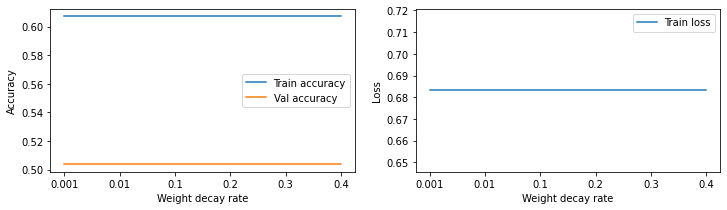


Batch size = 4 and learning rate = 2e-07


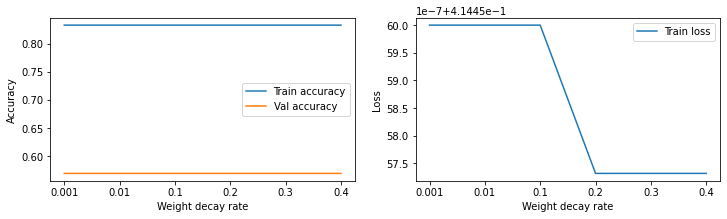


Batch size = 16 and learning rate = 2e-05


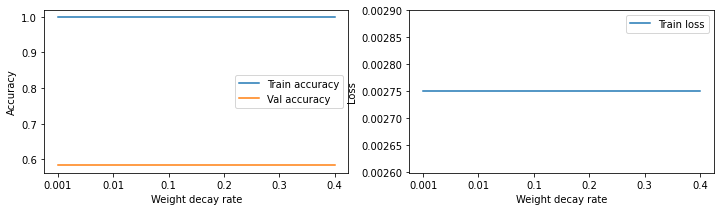


Batch size = 16 and learning rate = 2e-07


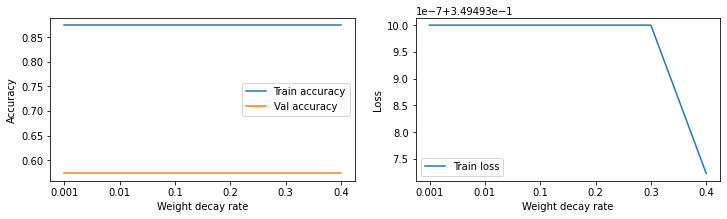


Batch size = 32 and learning rate = 2e-05


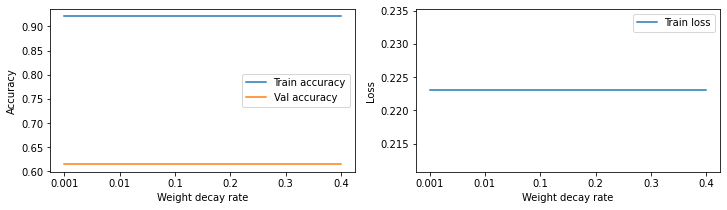


Batch size = 32 and learning rate = 2e-07


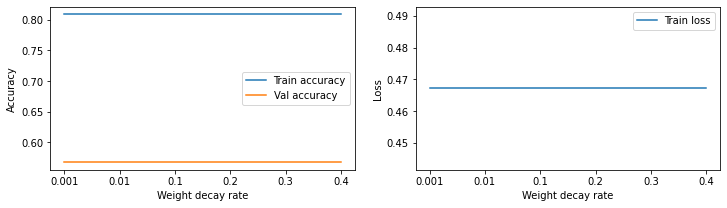

In [ ]:
print('Results of RuBERT')
for batch in sorted(list(set(df['Batch size']))):
  df2 = df[df['Batch size']==batch]
  for learning_rate in set(df['Learning rate']):
    print('\nBatch size =', batch, 'and learning rate =', learning_rate)
    df3 = df2[df2['Learning rate']==learning_rate]
    print_results(df3.iloc[::-1])

In [ ]:
df[df['Val accuracy']==df['Val accuracy'].max()]

,Train loss,Train accuracy,Val accuracy,Epoch,Learning rate,Weight decay rate,Batch size
24,0.223022,0.921293,0.614412,3,0.00002,0.400,32
25,0.223022,0.921293,0.614412,3,0.00002,0.300,32
26,0.223022,0.921293,0.614412,3,0.00002,0.200,32
27,0.223022,0.921293,0.614412,3,0.00002,0.100,32
28,0.223022,0.921293,0.614412,3,0.00002,0.010,32
29,0.223022,0.921293,0.614412,3,0.00002,0.001,32


Таким образом, оптимальные значения параметров для обучения модели RuBERT: batch_size=32, learning_rate=2e-5, epoch=3. Параметр weight_decay_rate при этом может любым из рассмотренных значений. 

Загрузка модели с оптимальными параметрами и её тестировние

In [ ]:
torch.save(model, path_to_dir+'RuBERT_model')

In [ ]:
model=torch.load(path_to_dir+'RuBERT_model')

In [ ]:
preds=predict(model, validation_inputs, validation_masks)
predicted_classes=np.argmax(preds, axis=1).flatten()
print(classification_report(validation_labels, predicted_classes, target_names=['False', 'True']))
print('Accuracy:', accuracy_score(validation_labels, predicted_classes))

              precision    recall  f1-score   support

       False       0.65      0.50      0.57       409
        True       0.60      0.74      0.66       412

    accuracy                           0.62       821
   macro avg       0.62      0.62      0.61       821
weighted avg       0.62      0.62      0.61       821

Accuracy: 0.6175395858708892


In [ ]:
preds=predict(model, test_inputs, test_masks)
predicted_classes=np.argmax(preds, axis=1).flatten()
print(classification_report(test_labels, predicted_classes, target_names=['False', 'True']))
print('Accuracy:', accuracy_score(test_labels, predicted_classes))

              precision    recall  f1-score   support

       False       0.68      0.56      0.61       210
        True       0.59      0.71      0.65       190

    accuracy                           0.63       400
   macro avg       0.64      0.63      0.63       400
weighted avg       0.64      0.63      0.63       400

Accuracy: 0.63


### Оценка модели на тестовых данных, в случае передачи модели только вопросов, без отрывков текста.

In [ ]:
model=torch.load(path_to_dir+'RuBERT_model')

In [ ]:
test_encoded_sequences2 = list(map(lambda q: tokenizer.encode_plus(q, max_length=100, pad_to_max_length=True, return_attention_mask = True), test_questions))

In [ ]:
test_encoded_sequences2[0]

{'input_ids': [101, 20177, 942, 36312, 801, 27369, 166, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [ ]:
x_test=[]
test_masks=[]
for seq in test_encoded_sequences2:
  x_test.append(seq['input_ids'])
  test_masks.append(seq['attention_mask'])
x_test=np.array(x_test)
test_masks=np.array(test_masks)

In [ ]:
y_test=[]
for i in range(test_data_len):
  y_test.append(int(test_data[i]['label']))
y_test=np.array(y_test)

In [ ]:
test_inputs = torch.tensor(x_test)
test_masks = torch.tensor(test_masks)
test_labels = torch.tensor(y_test)

In [ ]:
preds=predict(model, test_inputs, test_masks)
predicted_classes=np.argmax(preds, axis=1).flatten()
print(classification_report(test_labels, predicted_classes, target_names=['False', 'True']))
print('Accuracy:', accuracy_score(test_labels, predicted_classes))

              precision    recall  f1-score   support

       False       0.68      0.51      0.58       210
        True       0.58      0.74      0.65       190

    accuracy                           0.62       400
   macro avg       0.63      0.62      0.61       400
weighted avg       0.63      0.62      0.61       400

Accuracy: 0.6175


Предсказание модели на заданном вопросе

In [ ]:
question='Был ли Сталин?'
encoded_sequence = tokenizer.encode_plus(question, max_length=100, pad_to_max_length=True, return_attention_mask = True)

input=torch.tensor([encoded_sequence['input_ids']])
mask=torch.tensor([encoded_sequence['attention_mask']])

preds=predict(model, input, mask)
predicted_class=np.argmax(preds, axis=1)
bool(predicted_class)

True

## Multilingual BERT

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer 

# Define the model repo
model_name ='bert-base-multilingual-uncased'

# Download bert tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name)

In [ ]:
# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)
print(device)

cuda


In [ ]:
def predict(model, inputs, masks):
  model.eval()
  inputs=inputs.to(device)
  masks=masks.to(device)
  with torch.no_grad():
    # Forward pass, рассчитать логит-прогнозы
    logits = model(inputs, token_type_ids=None, attention_mask=masks)    
  # Переместить logits и labels на CPU
  logits = logits[0].detach().cpu().numpy()
  return logits

### Дообучение модели BERT и оптимизация её гиперпараметров.

Получение токенов для текста.

In [ ]:
encoded_sequences = list(map(lambda q, p: tokenizer.encode_plus(q, p, max_length=100, pad_to_max_length=True, return_attention_mask = True), questions, passages))

In [ ]:
test_encoded_sequences = list(map(lambda q, p: tokenizer.encode_plus(q, p, max_length=100, pad_to_max_length=True, return_attention_mask = True), test_questions, test_passages))

In [ ]:
test_encoded_sequences[0]

{'input_ids': [101, 22889, 31550, 23029, 16804, 16609, 33400, 10124, 90595, 68680, 15491, 136, 102, 10842, 12630, 16421, 10571, 74920, 10260, 10414, 17830, 92112, 10260, 89212, 11027, 20720, 90595, 68680, 11136, 309, 87472, 22547, 10432, 62844, 60277, 59958, 95036, 16486, 10178, 22936, 24696, 10242, 48438, 60384, 12783, 11000, 34399, 13546, 15491, 11637, 100, 10360, 51489, 18596, 90595, 68680, 19304, 119, 32232, 10396, 34714, 325, 74709, 45824, 10236, 10535, 17547, 117, 11299, 28894, 58675, 12088, 10908, 118, 90595, 14738, 10360, 25511, 12347, 45853, 15092, 309, 45091, 23029, 80077, 118, 23858, 39800, 47057, 11863, 119, 10291, 18296, 83493, 12538, 10291, 320, 10395, 34478, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Преобразование обучающей, валидационной и тестовой выборок.

In [ ]:
y_train=[]
y_val=[]
y_test=[]

for i in range(train_data_len):
  y_train.append(int(train_data[i]['label']))

for j in range(val_data_len):
  y_val.append(int(val_data[j]['label']))

for i in range(test_data_len):
  y_test.append(int(test_data[i]['label']))

y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)

In [ ]:
x_train=[]
x_val=[]
x_test=[]

for seq in encoded_sequences[:train_data_len]:
  x_train.append(seq['input_ids'])
for seq in encoded_sequences[train_data_len:train_data_len+val_data_len]:
  x_val.append(seq['input_ids'])
for seq in test_encoded_sequences:
  x_test.append(seq['input_ids'])

x_train=np.array(x_train)
x_val=np.array(x_val)
x_test=np.array(x_test)

In [ ]:
train_masks=[]
validation_masks=[]
test_masks=[]

for seq in encoded_sequences[:train_data_len]:
  train_masks.append(seq['attention_mask'])
for seq in encoded_sequences[train_data_len:train_data_len+val_data_len]:
  validation_masks.append(seq['attention_mask'])
for seq in test_encoded_sequences:
  test_masks.append(seq['attention_mask'])

train_masks=np.array(train_masks)
validation_masks=np.array(validation_masks)
test_masks=np.array(test_masks)

In [ ]:
# Перемешивание x_train и y_train

randomize = np.arange(len(y_train))
np.random.shuffle(randomize)

x_train = x_train[randomize]
y_train = y_train[randomize]
train_masks = train_masks[randomize]

In [ ]:
# Выберите размер батча для обучения.
batch_size = 32

# Преобразование всех наших данных в тензоры pytorch, требуемый тип данных для нашей модели
train_inputs = torch.tensor(x_train)
validation_inputs = torch.tensor(x_val)
test_inputs = torch.tensor(x_test)

train_labels = torch.tensor(y_train)
validation_labels = torch.tensor(y_val)
test_labels = torch.tensor(y_test)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks = torch.tensor(test_masks)


# Создаем итератор наших данных с помощью torch DataLoader
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

validation_dataset = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_dataset)
validation_dataloader = DataLoader(validation_dataset, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
# Функция для расчета точности наших прогнозов по сравнению с метками
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def model_fine_tuning(epochs, model, train_dataloader, validation_dataloader, optimizer):
  torch.cuda.empty_cache() 
  max_val_dict = {'train_loss': 0.0, 'train_acc': 0.0, 'val_acc': 0.0, 'epoch': 0}
  # Сохраняем наши loss и точность для построения графика
  train_loss_set = []
  train_acc_set = []
  eval_acc_set = []
  # BERT - цикл обучения модели
  for epoch in trange(epochs, desc='Epoch'):  
  
  ## Обучение
  
  # Установите нашу модель в режим обучения
    model.train()  
    # Отслеживание переменных
    tr_loss = 0
    tr_accuracy=0
    nb_tr_examples, nb_tr_steps = 0, 0
    # Обучение на данных для одной эпохи
    for step, batch in enumerate(train_dataloader):
      # Добавить пакет в GPU
      batch = tuple(t.to(device) for t in batch)
      # Распакуйте входные данные из нашего загрузчика данных
      b_input_ids, b_input_mask, b_labels = batch
      # Очистите градиенты (по умолчанию они накапливаются)
      optimizer.zero_grad()
      # Forward pass
      model_result = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
      loss=model_result[0]
      train_loss_set.append(loss.item())  

      # Backward pass
      loss.backward()
      # Обновите параметры и сделайте шаг, используя вычисленный градиент
      optimizer.step()
      # Обновить переменные
      tr_loss += loss.item()
      nb_tr_examples += b_input_ids.size(0)
      nb_tr_steps += 1

      with torch.no_grad():
        # Forward pass, рассчитать логит-прогнозы
        logits = model_result[1]     
      # Переместить logits и labels на CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      tmp_tr_accuracy = flat_accuracy(logits, label_ids)  
      train_acc_set.append(tmp_tr_accuracy)  
      tr_accuracy += tmp_tr_accuracy
      
    avg_train_acc = tr_accuracy/nb_tr_steps
    avg_train_loss = tr_loss/nb_tr_steps
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    print("Train Accuracy: {}".format(tr_accuracy/nb_tr_steps))
       
   ## VALIDATION

    # Поместите модель в режим валидации
    model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch
      with torch.no_grad():
        # Forward pass, рассчитать логит-прогнозы
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      # Переместить logits и labels на CPU
      logits = logits[0].detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
      eval_acc_set.append(tmp_eval_accuracy) 
      eval_accuracy += tmp_eval_accuracy
      nb_eval_steps += 1
    avg_val_acc=eval_accuracy/nb_eval_steps
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    if avg_val_acc > max_val_dict['val_acc']:
      max_val_dict['val_acc'] = avg_val_acc
      max_val_dict['train_acc'] = avg_train_acc
      max_val_dict['train_loss'] = avg_train_loss
      max_val_dict['epoch'] = epoch+1
  return max_val_dict
  # Отрисовать ход обучения
  plt.figure(figsize=(15,8))
  plt.plot(train_loss_set)
  plt.xlabel('Batch')
  plt.ylabel('Loss')
  plt.title("Training loss")

  plt.show()

In [ ]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
if torch.cuda.is_available():
  torch.cuda.empty_cache()
  print(model.cuda())
else:
  print(model)

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/672M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
columns = ['Train loss', 'Train accuracy', 'Val accuracy', 'Epoch', 'Learning rate', 'Weight decay rate', 'Batch size']
path_to_file = path_to_dir+'bert_model_params.csv'

In [ ]:
weight_decay_rates=[0.4, 0.3, 0.2, 0.1, 0.01, 0.001]
learning_rates = [2e-5, 2e-7]

In [ ]:
# Количество эпох обучения
epochs = 4

lr=learning_rates[0]
weight_decay_rate=weight_decay_rates[0]
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate': weight_decay_rate},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                    lr=lr,
                    warmup=.1)

max_val_dict = model_fine_tuning(epochs, model, train_dataloader, validation_dataloader, optimizer)
max_val_epoch=max_val_dict['epoch']

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.6572058471766385
Train Accuracy: 0.602732683982684


Epoch:  25%|██▌       | 1/4 [00:38<01:56, 38.87s/it]

Validation Accuracy: 0.5046359890109889
Train loss: 0.6042977186766538
Train Accuracy: 0.6642045454545454


Epoch:  50%|█████     | 2/4 [01:15<01:14, 37.31s/it]

Validation Accuracy: 0.5665064102564102
Train loss: 0.4909265144304796
Train Accuracy: 0.7766233766233767


Epoch:  75%|███████▌  | 3/4 [01:52<00:37, 37.49s/it]

Validation Accuracy: 0.6314102564102565
Train loss: 0.34047548391602256
Train Accuracy: 0.8550865800865801


Epoch: 100%|██████████| 4/4 [02:32<00:00, 38.02s/it]

Validation Accuracy: 0.6505265567765567


In [ ]:
result=[[max_val_dict['train_loss'], max_val_dict['train_acc'],  max_val_dict['val_acc'],  max_val_epoch, lr, weight_decay_rate, batch_size]]

save_to_file(result, columns, path_to_file)

Представление результатов подбора параметров в виде графиков

In [ ]:
if os.path.exists(path_to_file)==True:
  df=pd.read_csv(path_to_file)
  df.drop('Unnamed: 0', axis = 1, inplace=True)
df.head(30)

,Train loss,Train accuracy,Val accuracy,Epoch,Learning rate,Weight decay rate,Batch size
0,0.340475,0.855087,0.650527,4,2.000000e-05,0.400,32
1,0.021970,0.993182,0.579155,8,2.000000e-05,0.300,32
2,0.070959,0.976136,0.595295,6,2.000000e-05,0.200,32
3,0.070959,0.976136,0.595295,6,2.000000e-05,0.100,32
4,0.070959,0.976136,0.595295,6,2.000000e-05,0.010,32
5,0.686639,0.592208,0.504636,1,2.000000e-05,0.001,32
6,0.687735,0.547078,0.504636,1,2.000000e-07,0.400,32
7,0.687735,0.547078,0.504636,1,2.000000e-07,0.300,32
8,0.687735,0.547078,0.504636,1,2.000000e-07,0.200,32
9,0.687735,0.547078,0.504636,1,2.000000e-07,0.100,32


In [ ]:
def print_results(df):
  
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
  indices_array=sorted(list(set(df['Weight decay rate'])))
  indices=list(map(lambda d: str(d), indices_array))
  df2=df
  df2.index=indices

  ax[0].set(xlabel='Weight decay rate', ylabel='Accuracy')
  ax[0].plot(df2['Train accuracy'],  label='Train accuracy') 
  ax[0].plot(df2['Val accuracy'], label='Val accuracy')
  ax[0].legend()

  ax[1].set(xlabel='Weight decay rate', ylabel='Loss')
  ax[1].plot(df2['Train loss'],  label='Train loss') 
  ax[1].legend()

  plt.show()

Results of BERT

Batch size = 16 and learning rate = 2e-05


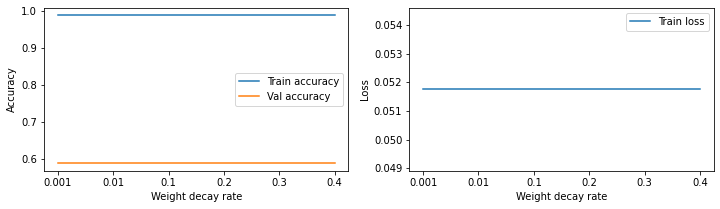


Batch size = 16 and learning rate = 2e-07


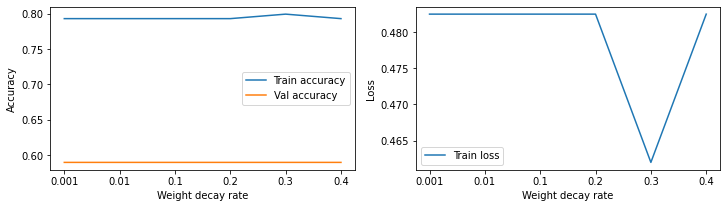


Batch size = 32 and learning rate = 2e-05


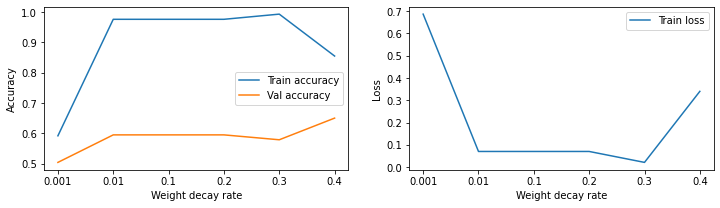


Batch size = 32 and learning rate = 2e-07


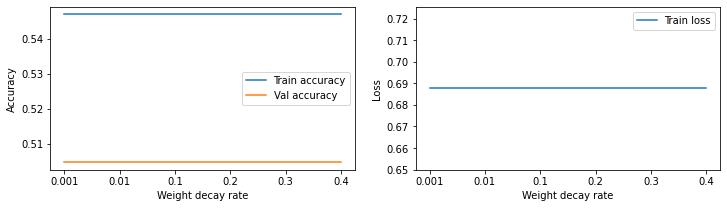


Batch size = 64 and learning rate = 2e-05


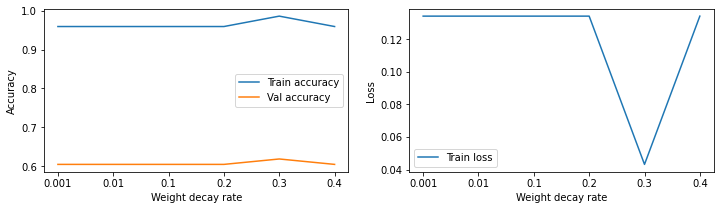


Batch size = 64 and learning rate = 2e-07


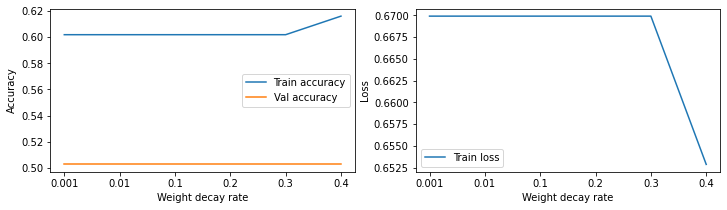

In [ ]:
print('Results of BERT')
for batch in sorted(list(set(df['Batch size']))):
  df2 = df[df['Batch size']==batch]
  for learning_rate in set(df['Learning rate']):
    print('\nBatch size =', batch, 'and learning rate =', learning_rate)
    df3 = df2[df2['Learning rate']==learning_rate]
    print_results(df3.iloc[::-1])

In [ ]:
df[df['Val accuracy']==df['Val accuracy'].max()]

,Train loss,Train accuracy,Val accuracy,Epoch,Learning rate,Weight decay rate,Batch size
0,0.340475,0.855087,0.650527,4,0.00002,0.4,32


Таким образом, оптимальные значения параметров для обучения модели RuBERT: batch_size=32, learning_rate=2e-5, epoch=4, weight_decay_rate=0.4.

Загрузка модели с оптимальными параметрами и её тестировние

In [ ]:
torch.save(model, path_to_dir+'BERT_model')

In [ ]:
model=torch.load(path_to_dir+'BERT_model')

In [ ]:
preds=predict(model, validation_inputs, validation_masks)
predicted_classes=np.argmax(preds, axis=1).flatten()
print(classification_report(validation_labels, predicted_classes, target_names=['False', 'True']))
print('Accuracy:', accuracy_score(validation_labels, predicted_classes))

              precision    recall  f1-score   support

       False       0.69      0.54      0.61       409
        True       0.63      0.76      0.69       412

    accuracy                           0.65       821
   macro avg       0.66      0.65      0.65       821
weighted avg       0.66      0.65      0.65       821

Accuracy: 0.6528623629719854


In [ ]:
preds=predict(model, test_inputs, test_masks)
predicted_classes=np.argmax(preds, axis=1).flatten()
print(classification_report(test_labels, predicted_classes, target_names=['False', 'True']))
print('Accuracy:', accuracy_score(test_labels, predicted_classes))

              precision    recall  f1-score   support

       False       0.71      0.62      0.66       210
        True       0.63      0.72      0.67       190

    accuracy                           0.67       400
   macro avg       0.67      0.67      0.67       400
weighted avg       0.68      0.67      0.67       400

Accuracy: 0.67


### Оценка модели на тестовых данных, в случае передачи модели только вопросов, без отрывков текста.

In [ ]:
model=torch.load(path_to_dir+'BERT_model')

In [ ]:
test_encoded_sequences2 = list(map(lambda q: tokenizer.encode_plus(q, max_length=100, pad_to_max_length=True, return_attention_mask = True), test_questions))

In [ ]:
test_encoded_sequences2[0]

{'input_ids': [101, 22889, 31550, 23029, 16804, 16609, 33400, 10124, 90595, 68680, 15491, 136, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
x_test=[]
test_masks=[]
for seq in test_encoded_sequences2:
  x_test.append(seq['input_ids'])
  test_masks.append(seq['attention_mask'])
x_test=np.array(x_test)
test_masks=np.array(test_masks)

In [ ]:
y_test=[]
for i in range(test_data_len):
  y_test.append(int(test_data[i]['label']))
y_test=np.array(y_test)

In [ ]:
test_inputs = torch.tensor(x_test)
test_masks = torch.tensor(test_masks)
test_labels = torch.tensor(y_test)

In [ ]:
preds=predict(model, test_inputs, test_masks)
predicted_classes=np.argmax(preds, axis=1).flatten()
print(classification_report(test_labels, predicted_classes, target_names=['False', 'True']))
print('Accuracy:', accuracy_score(test_labels, predicted_classes))

              precision    recall  f1-score   support

       False       0.72      0.59      0.65       210
        True       0.62      0.75      0.68       190

    accuracy                           0.67       400
   macro avg       0.67      0.67      0.66       400
weighted avg       0.67      0.67      0.66       400

Accuracy: 0.665


Предсказание модели на заданном вопросе

In [ ]:
question='вопрос?' # тут задаем вопрос
encoded_sequence = tokenizer.encode_plus(question, max_length=100, pad_to_max_length=True, return_attention_mask = True)

input=torch.tensor([encoded_sequence['input_ids']])
mask=torch.tensor([encoded_sequence['attention_mask']])

preds=predict(model, input, mask)
predicted_class=np.argmax(preds, axis=1)
bool(predicted_class)

True

In [ ]:
question='вопрос' # тут задаем вопрос
encoded_sequence = tokenizer.encode_plus(question, max_length=100, pad_to_max_length=True, return_attention_mask = True)

input=torch.tensor([encoded_sequence['input_ids']])
mask=torch.tensor([encoded_sequence['attention_mask']])

preds=predict(model, input, mask)
predicted_class=np.argmax(preds, axis=1)
bool(predicted_class)

True